# Setup

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr  3 13:07:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   32C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install -q pyspark==3.5.5 spark-nlp==5.5.3

# Can also use the script below but the pyspark version is incompatible.
# !wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 13.4 MB/s eta 0:00:00



**How to prevent Google Colab from disconnecting?**

Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. This means, if user does not interact with his Google Colab notebook for more than 90 minutes, its instance is automatically terminated. Also, maximum lifetime of a Colab instance is **12 hours.**

Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with Ctrl+Shift+I then click on console tab and type this on the console prompt. (for mac press Option+Command+I)



In [ ]:
'''
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);

'''

'\nfunction ConnectButton(){\n    console.log("Connect pushed");\n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()\n}\nsetInterval(ConnectButton,60000);\n\n'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.2 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_ver

In [ ]:
from skl2onnx import __max_supported_opset__, __version__

print("documentation for version:", __version__)
print("Last supported opset:", __max_supported_opset__)

documentation for version: 1.18.0
Last supported opset: 21


## Start Spark Session

In [ ]:
%%time


import sparknlp

spark = sparknlp.start(gpu=True)

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 5.5.3
Apache Spark version: 3.5.5
CPU times: user 2.15 s, sys: 162 ms, total: 2.31 s
Wall time: 58.6 s


# Train Sentence-Level Bias Classifier

## Data Preparation
https://ethical-spectacle-research.gitbook.io/rumormill/research/datasets/babe-dataset-2022

In [ ]:
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
import ast
from sparknlp.annotator import StopWordsCleaner
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
# Load the pretrained stopwords model (for English) and retrieve its stopwords list
pretrained_stop_model = StopWordsCleaner.pretrained("stopwords_en", "en")
default_stopwords = set(pretrained_stop_model.getStopWords())

def filter_biased_words(word_list):
    # Remove words present in the default stopwords list (case-insensitive)
    return [w for w in word_list if w.lower() not in default_stopwords]

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
babe_dataset_train = load_dataset("mediabiasgroup/BABE", split="train")
babe_dataset_test = load_dataset("mediabiasgroup/BABE", split="test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/770 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/712k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3121 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Convert the Hugging Face dataset to a pandas DataFrame
babe_pd_train = babe_dataset_train.to_pandas()
babe_pd_test = babe_dataset_test.to_pandas()

In [ ]:
assert(len(babe_pd_train) == 3121)
assert(len(babe_pd_test) == 1000)

In [ ]:
print(babe_pd_train.columns)

Index(['text', 'outlet', 'label', 'topic', 'news_link', 'biased_words', 'uuid',
       'type', 'label_opinion'],
      dtype='object')


In [ ]:
print(babe_pd_test.columns)

Index(['text', 'outlet', 'label', 'topic', 'news_link', 'biased_words', 'uuid',
       'type', 'label_opinion'],
      dtype='object')


Columns of the BABE dataset:
*   "text": The text fragment (few sentences or less).
*   "outlet": The source of the text fragments.
*   "label": 0 or 1 (biased or unbiased).
*   "topic": The subject of the text fragment.
*   "news_link": URL to the original source.
*   "biased_words": Full words contributing to bias, in a list.
*   "type": Political sentiment (if applicable).
*   "label_opinion": opinion label for the sentence ("Expresses writer's opinion" or "Somewhat factual but also opinionated" or "Entirely factual")



In [ ]:
# Print the text column from a row
print(babe_pd_train['text'][3])
print(type(babe_pd_train['text'][3]))

The curfews, which have never before occurred on an Election Day in recent times, were a response to looting that occurred after generally peaceful protests against police violence and racism. However, the curfews also come in a climate where the Republican Party, led by President Trump, has been repeatedly making false claims that voting by mail is rife with fraud
<class 'str'>


In [ ]:
# Print the 'biased_words' column from the same row
print(babe_pd_train['biased_words'][3])
print(type(babe_pd_train['biased_words'][3]))

['false', 'claims']
<class 'str'>


In [ ]:
# Print the 'label' column from the same row
print(babe_pd_train['label'][3])
print(type(babe_pd_train['label'][3]))

1
<class 'numpy.int32'>


In [ ]:
# Print all possible values of the column 'label'
print(babe_pd_train['label'].unique())
print(type(babe_pd_train['label'][3]))

[0 1]
<class 'numpy.int32'>


In [ ]:
# Print all possible values of the column 'topic'
print(babe_pd_train['topic'].unique())
print(type(babe_pd_train['topic'][3]))

['marriage-equality' 'islam' 'elections-2020' '#metoo' 'vaccine'
 'international-politics-and-world-news' 'white-nationalism' 'taxes'
 'immigration' 'coronavirus' 'sport' 'middle-class' 'abortion'
 'trump-presidency' 'gun-control' 'environment' 'gun control'
 'black lives matter' 'student-debt' 'vaccines' 'gender' 'blm'
 'universal health care']
<class 'str'>


In [ ]:
# Print all possible values of the column 'type'
print(babe_pd_train['type'].unique())
print(type(babe_pd_train['type'][3]))

[None 'left' 'center' 'right']
<class 'str'>


In [ ]:
# Print all the lengths of the list in the column `biased_words`
print(babe_pd_train['biased_words'][3])
print(type(babe_pd_train['biased_words'][3]))

['false', 'claims']
<class 'str'>


In [ ]:
# Print all the possible values of the column 'outlet'
print(babe_pd_train['outlet'].unique())
print(type(babe_pd_train['outlet'][3]))

['Breitbart' 'Federalist' 'Alternet' 'Reuters' 'USA Today' 'The Guardian'
 'Fox News' 'MSNBC' 'The Daily Beast' 'The Federalist' 'Daily Beast'
 'HuffPost' 'TheBlaze' 'Huffpost' 'New York Post' 'UCSD Guardian'
 'Daily Stormer' 'New York Times']
<class 'str'>


In [ ]:
# Print all possible values of the column 'label_opinion'
print(babe_pd_train['label_opinion'].unique())

['Entirely factual' 'Expresses writer’s opinion'
 'Somewhat factual but also opinionated' None 'No agreement']


## Data Preprocessing

In [ ]:
# Convert to a Spark DataFrame
babe_train_df = spark.createDataFrame(babe_pd_train)

In [ ]:
# Drop the "news_link" column since it's not needed
babe_train_df = babe_train_df.drop("news_link")

In [ ]:
# Filter out rows where label_opinion is None (missing)
babe_train_df = babe_train_df.filter(col("label_opinion").isNotNull())

In [ ]:
# (Optional) Decide what to do with rows where label_opinion equals "No agreement"
# For now, we keep them; if you wish to remove them, uncomment the next line:
babe_train_df = babe_train_df.filter(col("label_opinion") != "No agreement")

In [ ]:
# Process the "biased_words" column
# It is a string representation of a list (e.g., "['false', 'claims']")
def parse_biased_words(text):
    try:
        # Safely evaluate the string as a Python list
        words = ast.literal_eval(text)
        if isinstance(words, list):
            return words
        else:
            return []
    except:
        return []

In [ ]:
parse_biased_words_udf = udf(parse_biased_words, ArrayType(StringType()))
babe_train_df = babe_train_df.withColumn("biased_words_list", parse_biased_words_udf(col("biased_words")))
# Optionally drop the original biased_words column
babe_train_df = babe_train_df.drop("biased_words")

In [ ]:
# Print the first three rows' biased_words_list values
print(babe_train_df.select("biased_words_list").take(3))

[Row(biased_words_list=[]), Row(biased_words_list=['indoctrinating', 'Marxist', 'alarming']), Row(biased_words_list=['what', 'the', 'hell'])]


In [ ]:
# Remove stop words from `biased_words_list`
filter_biased_words_udf = udf(filter_biased_words, ArrayType(StringType()))
babe_df = babe_train_df.withColumn("biased_words_list", filter_biased_words_udf(col("biased_words_list")))

In [ ]:
# Print the first three rows' biased_words_list values
print(babe_train_df.select("biased_words_list").take(3))

[Row(biased_words_list=[]), Row(biased_words_list=['indoctrinating', 'Marxist', 'alarming']), Row(biased_words_list=['what', 'the', 'hell'])]


In [ ]:
# Drop the 'uuid' column if it exists
if "uuid" in babe_df.columns:
    babe_df = babe_df.drop("uuid")

In [ ]:
# Rename 'label' to 'label_bias'
babe_train_df = babe_train_df.withColumnRenamed("label", "label_bias")

In [ ]:
# Rename 'type' to 'outlet_political_orientation'
babe_train_df = babe_train_df.withColumnRenamed("type", "outlet_political_orientation")

In [ ]:
# Show a map of all outlets and outlet_political_orientation
babe_train_df.groupBy("outlet", "outlet_political_orientation").count().show()

+--------------+----------------------------+-----+
|        outlet|outlet_political_orientation|count|
+--------------+----------------------------+-----+
|     USA Today|                        NULL|   29|
|         MSNBC|                        left|  163|
|      Fox News|                       right|   78|
|       Reuters|                      center|  394|
|   Daily Beast|                        NULL|   32|
|    Federalist|                        NULL|   89|
|      Alternet|                        NULL|  100|
|         MSNBC|                        NULL|   26|
|       Reuters|                        NULL|  165|
|      Alternet|                        left|  426|
|      Fox News|                        NULL|  104|
|New York Times|                        NULL|    1|
|     Breitbart|                       right|  489|
|     Breitbart|                        NULL|  183|
|    Federalist|                       right|  144|
|      HuffPost|                        NULL|    5|
|     USA To

In [ ]:
# Impute missing outlet political orientation from Allsides.com
impute_mapping = {
    'USA Today': 'left',
    'Daily Beast': 'left',
    'Federalist': 'right',
    'Alternet': 'left',
    'MSNBC': 'left',
    'Reuters': 'center',
    'Fox News': 'right',
    'New York Times': 'left',
    'Breitbart': 'right',
    'HuffPost': 'left',
    'Daily Stormer': 'right',
}

In [ ]:
def impute_orientation(orientation, outlet):
    if orientation is None or orientation.strip() == "":
        return impute_mapping.get(outlet, None)
    else:
        return orientation

impute_orientation_udf = udf(impute_orientation, StringType())
babe_train_df = babe_train_df.withColumn("outlet_political_orientation",
                             impute_orientation_udf(col("outlet_political_orientation"), col("outlet")))

In [ ]:
# Show a map of all outlets and outlet_political_orientation
babe_train_df.groupBy("outlet", "outlet_political_orientation").count().show()

+--------------+----------------------------+-----+
|        outlet|outlet_political_orientation|count|
+--------------+----------------------------+-----+
|         MSNBC|                        left|  189|
|      Fox News|                       right|  182|
|       Reuters|                      center|  559|
| Daily Stormer|                       right|    5|
|     USA Today|                        left|   29|
|New York Times|                        left|    1|
|      Alternet|                        left|  526|
|     Breitbart|                       right|  672|
|    Federalist|                       right|  233|
|     USA Today|                      center|  104|
|   Daily Beast|                        left|   32|
|      HuffPost|                        left|   81|
+--------------+----------------------------+-----+



In [ ]:
# Check the schema and a few rows of the cleaned dataset
def print_schema_and_sample(df, num_rows=5):
    df.printSchema()
    df.show(num_rows, truncate=False)


print_schema_and_sample(babe_train_df, 20)

root
 |-- text: string (nullable = true)
 |-- outlet: string (nullable = true)
 |-- label_bias: long (nullable = true)
 |-- topic: string (nullable = true)
 |-- uuid: string (nullable = true)
 |-- outlet_political_orientation: string (nullable = true)
 |-- label_opinion: string (nullable = true)
 |-- biased_words_list: array (nullable = true)
 |    |-- element: string (containsNull = true)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------+-------------------------------------+----------------------+----------------------------+-------------------------------------+--------------------------------------------+
|text                                    

In [ ]:
# Convert the 'label_opinion' column to numeric using StringIndexer,
# but note that this column (as "label_opinion_index") will not be included in feature assembly.
from pyspark.ml.feature import StringIndexer
indexer_opinion = StringIndexer(inputCol="label_opinion", outputCol="label_opinion_index")
babe_train_df = indexer_opinion.fit(babe_train_df).transform(babe_train_df)

In [ ]:
# Load a pretrained Spark NLP pipeline (e.g., "explain_document_ml")
nlp_pipeline = PretrainedPipeline("explain_document_ml", lang="en")

explain_document_ml download started this may take some time.
Approx size to download 9 MB
[OK!]


In [ ]:
# Create a StopWordsCleaner stage that uses the pretrained defaults
# (by not setting custom stopwords).
from sparknlp.annotator import StopWordsCleaner
stopwords_cleaner = StopWordsCleaner().pretrained('stopwords_iso', 'en') \
    .setInputCols(["token"]) \
    .setOutputCol("cleanTokens")

stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[OK!]


In [ ]:
# Retrieve the default stages from the pretrained pipeline and append the StopWordsCleaner stage.
from pyspark.ml import Pipeline
default_stages = nlp_pipeline.model.stages
custom_pipeline = Pipeline(stages=default_stages + [stopwords_cleaner])

In [ ]:
# Fit and transform the BABE DataFrame using the custom pipeline.
annotated_train_df = custom_pipeline.fit(babe_train_df).transform(babe_train_df)

In [ ]:
# Define a UDF to extract the 'result' field from each annotation in the "cleanTokens" column.
def extract_token_results(annotations):
    return [ann.result for ann in annotations] if annotations else []

extract_tokens_udf = udf(extract_token_results, ArrayType(StringType()))

In [ ]:
# Add a new column "processed_tokens" containing the cleaned token strings.
annotated_train_df = annotated_train_df.withColumn("processed_tokens", extract_tokens_udf(col("cleanTokens")))

In [ ]:
import re


def clean_tokens(token_list):
    cleaned = []
    for token in token_list:
        # Replace commas and hyphens with space and split into sub-tokens
        sub_tokens = token.replace(",", " ").replace("-", " ").split()
        for t in sub_tokens:
            t = t.strip()
            # Skip empty tokens
            if not t:
                continue
            # Only keep tokens that have at least one alphanumeric character
            if any(char.isalnum() for char in t):
                cleaned.append(t)
    return cleaned

clean_tokens_udf = udf(clean_tokens, ArrayType(StringType()))

# Apply the UDF to the "processed_tokens" column to produce a cleaned version.
annotated_train_df = annotated_train_df.withColumn("processed_tokens_clean", clean_tokens_udf(col("processed_tokens")))

In [ ]:
annotated_train_df.select("processed_tokens_clean").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|processed_tokens_clean                                                                                                                                                                                                                                                 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[NYPD, Commissioner, Dermot, Shea, Monday, expressed, support, diverting, funds, away, police, department, areas, like, youth, programs]                                                                 

In [ ]:
# Load test split and apply the same preprocessing steps as done for training.
babe_test_df = spark.createDataFrame(babe_pd_test)

# (Apply cleaning: drop 'uuid', rename columns, impute missing outlet_political_orientation,
#  process biased_words, filter out null label_opinion, etc.)
babe_test_df = babe_test_df.drop("news_link")
if "uuid" in babe_test_df.columns:
    babe_test_df = babe_test_df.drop("uuid")
babe_test_df = babe_test_df.withColumnRenamed("label", "label_bias")
babe_test_df = babe_test_df.withColumnRenamed("type", "outlet_political_orientation")
babe_test_df = babe_test_df.withColumn("biased_words_list", parse_biased_words_udf(col("biased_words"))).drop("biased_words")
babe_test_df = babe_test_df.filter(col("label_opinion").isNotNull())
babe_test_df = babe_test_df.withColumn("outlet_political_orientation",
                             impute_orientation_udf(col("outlet_political_orientation"), col("outlet")))
babe_test_df = babe_test_df.withColumn("biased_words_list", filter_biased_words_udf(col("biased_words_list")))
babe_test_df = indexer_opinion.fit(babe_test_df).transform(babe_test_df)

# Preprocess the "text" column using the NLP pipeline (assume custom_pipeline is from training)
annotated_test_df = custom_pipeline.fit(babe_test_df).transform(babe_test_df)
annotated_test_df = annotated_test_df.withColumn("processed_tokens", extract_tokens_udf(col("cleanTokens")))
annotated_test_df = annotated_test_df.withColumn("processed_tokens_clean", clean_tokens_udf(col("processed_tokens")))

## Baseline Classifier with TF-IDF and Logistic Regression

In [ ]:
from pyspark.ml.feature import CountVectorizer, StringIndexer, VectorAssembler, Word2Vec, IDF
from pyspark.ml import Pipeline as MLPipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

In [ ]:
# Vectorize the processed_tokens (from the text) using CountVectorizer
# Then, apply IDF to obtain TF-IDF features.
# Use a simple Logistic Regression for now.
# Concat the operations together into a pipeline
def train_model(train_df, featuresCol, labelCol, classifier_model=None):
  # If no classifier is passed, use LogisticRegression by default.
  if classifier_model is None:
    classifier_model = LogisticRegression(featuresCol="tfidf_features", labelCol=labelCol, maxIter=10)

  cv = CountVectorizer(inputCol=featuresCol,
                            outputCol="raw_tf",
                            vocabSize=5000,
                            minDF=1)
  idf = IDF(inputCol="raw_tf", outputCol="tfidf_features")

  pipeline = Pipeline(stages=[cv, idf, classifier_model])

  gridBuilder = ParamGridBuilder() \
                    .addGrid(cv.vocabSize, [100000, 150000]) \
                    .addGrid(cv.minDF, [1, 2, 3]) \
                    .addGrid(cv.minTF, [1, 2])

  if hasattr(classifier_model, "regParam"):
        gridBuilder = gridBuilder.addGrid(classifier_model.regParam, [0.0, 0.01, 0.1])

  paramGrid = gridBuilder.build()

  evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="f1")

  crossval = CrossValidator(estimator=pipeline,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            numFolds=3)  # Use 3-fold cross validation

  cvModel = crossval.fit(train_df)
  return cvModel.bestModel, evaluator

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol="tfidf_features", labelCol="label_bias")

# Train the model for label bias
best_bias_model, bias_evaluator = train_model(annotated_train_df, 'processed_tokens_clean', 'label_bias', classifier_model=None)

# Use the best model on the test data
test_predictions = best_bias_model.transform(annotated_test_df)
test_accuracy = bias_evaluator.evaluate(test_predictions)
print("Test Accuracy: {:.3f}".format(test_accuracy))

Test Accuracy: 0.725


In [ ]:
# # Train the model for label opinion
# best_opinion_model, opinion_evaluator = train_model(annotated_train_df, 'processed_tokens_clean', 'label_opinion_index', classifier_model=None)

# test_predictions = best_opinion_model.transform(annotated_test_df)
# test_accuracy = opinion_evaluator.evaluate(test_predictions)
# print("Test Accuracy: {:.3f}".format(test_accuracy))

In [ ]:
# # Save both models for later use
# best_bias_model.save("path/to/sentence_level_bias_model")
# best_opinion_model.save("path/to/sentence_level_opinion_model")

## Transformer-based Embedding Model and Deep Learning

In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

In [ ]:
# document = DocumentAssembler() \
#       .setInputCol("text") \
#       .setOutputCol("document")

# sentence = SentenceDetector() \
#       .setInputCols(["document"]) \
#       .setOutputCol("sentence")

# embeddings = BertSentenceEmbeddings.pretrained() \
#       .setInputCols(["sentence"]) \
#       .setOutputCol("sentence_bert_embeddings")

# classifier = ClassifierDLApproach() \
#       .setInputCols(["sentence_bert_embeddings"]) \
#       .setOutputCol("class") \
#       .setLabelColumn("label_bias") \
#       .setMaxEpochs(10) \
#       .setEnableOutputLogs(True) \

# pipeline = Pipeline(
#     stages = [
#       document,
#       sentence,
#       embeddings,
#       classifier
#     ])

document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence_embeddings")

classsifierdl = ClassifierDLApproach().setInputCols(["sentence_embeddings"]) \
    .setOutputCol("class") \
    .setLabelColumn("label_bias") \
    .setMaxEpochs(70) \
    .setEnableOutputLogs(True) \
    .setLr(0.004)

pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
%%time

model = pipeline.fit(annotated_train_df)
result_df = model.transform(annotated_test_df)

CPU times: user 190 ms, sys: 28.1 ms, total: 218 ms
Wall time: 41.1 s


In [ ]:
# Showing the classification result
result_df.select('text', 'label_bias', "class.result").show(20, truncate=120)

+------------------------------------------------------------------------------------------------------------------------+----------+------+
|                                                                                                                    text|label_bias|result|
+------------------------------------------------------------------------------------------------------------------------+----------+------+
|  As the Black Lives Matter movement grows, companies like Nike, Target, and Google have made Juneteenth a paid holiday.|         0|   [0]|
|The case of Rahaf Mohammed al-Qunun drawn new global attention to Saudi Arabia’s strict social rules, including a req...|         0|   [0]|
|The Post said the talks on payroll taxes were in the early stages and that officials had not decided whether to push ...|         0|   [0]|
|Colin P. Clarke has been teaching a course on terrorism and insurgency at Carnegie Mellon University in Pittsburgh fo...|         0|   [1]|
|Even while c

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
df = result_df.select('text', 'label_bias', "class.result").toPandas()
df['result'] = df['result'].apply(lambda x: int(x[0]))

In [ ]:
print(classification_report(df['label_bias'], df['result']))
print(accuracy_score(df['label_bias'], df['result']))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       380
           1       0.80      0.76      0.78       512

    accuracy                           0.75       892
   macro avg       0.75      0.75      0.75       892
weighted avg       0.76      0.75      0.76       892

0.7544843049327354


## Transformer-based Model with Word Embeddings and Text Preprocessing

In [ ]:
import sparknlp

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
import os

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

glove_embeddings = WordEmbeddingsModel().pretrained() \
    .setInputCols(["document",'lemma'])\
    .setOutputCol("embeddings")\
    .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("label_bias")\
    .setMaxEpochs(70)\
    .setEnableOutputLogs(True)
    #.setOutputLogsPath('logs')

clf_pipeline = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        normalizer,
        stopwords_cleaner,
        lemma,
        glove_embeddings,
        embeddingsSentence,
        classsifierdl
])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
'''
default classifierDL params:

    maxEpochs -> 10,
    lr -> 5e-3f,
    dropout -> 0.5f,
    batchSize -> 64,
    enableOutputLogs -> false,
    verbose -> Verbose.Silent.id,
    validationSplit -> 0.0f,
    outputLogsPath -> ""

'''

'\ndefault classifierDL params:\n\n    maxEpochs -> 10,\n    lr -> 5e-3f,\n    dropout -> 0.5f,\n    batchSize -> 64,\n    enableOutputLogs -> false,\n    verbose -> Verbose.Silent.id,\n    validationSplit -> 0.0f,\n    outputLogsPath -> ""\n\n'

In [ ]:
# Train (3 min for 3 epochs)
%%time

clf_pipelineModel = clf_pipeline.fit(annotated_train_df)

CPU times: user 136 ms, sys: 24.4 ms, total: 160 ms
Wall time: 22.4 s


In [ ]:
# get the predictions on test Set

preds = clf_pipelineModel.transform(annotated_test_df)

In [ ]:
preds.select('text','label_bias',"class.result").show(20, truncate=120)

+------------------------------------------------------------------------------------------------------------------------+----------+------+
|                                                                                                                    text|label_bias|result|
+------------------------------------------------------------------------------------------------------------------------+----------+------+
|  As the Black Lives Matter movement grows, companies like Nike, Target, and Google have made Juneteenth a paid holiday.|         0|   [0]|
|The case of Rahaf Mohammed al-Qunun drawn new global attention to Saudi Arabia’s strict social rules, including a req...|         0|   [0]|
|The Post said the talks on payroll taxes were in the early stages and that officials had not decided whether to push ...|         0|   [0]|
|Colin P. Clarke has been teaching a course on terrorism and insurgency at Carnegie Mellon University in Pittsburgh fo...|         0|   [1]|
|Even while c

In [ ]:
preds_df = preds.select('label_bias','text',"class.result").toPandas()

# The result is an array since in Spark NLP you can have multiple sentences.
# Let's explode the array and get the item(s) inside of result column out
preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))

In [ ]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print (classification_report(preds_df['label_bias'], preds_df['result']))
print(accuracy_score(preds_df['label_bias'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       380
           1       0.77      0.79      0.78       512

    accuracy                           0.75       892
   macro avg       0.74      0.74      0.74       892
weighted avg       0.75      0.75      0.75       892

0.7466367713004485


### with Bert embeddings

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

bert_embeddings = BertEmbeddings().pretrained(name='small_bert_L4_256', lang='en') \
    .setInputCols(["document",'token'])\
    .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("label_bias")\
    .setMaxEpochs(70)\
    .setLr(0.001)\
    .setEnableOutputLogs(True)
    #.setOutputLogsPath('logs')

bert_clf_pipeline = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        bert_embeddings,
        embeddingsSentence,
        classsifierdl
])

small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]


In [ ]:
# training will take some time due to Bert (use GPU runtime when possible)

%%time

bert_clf_pipelineModel = bert_clf_pipeline.fit(annotated_train_df)

log_file_name = os.listdir("/root/annotator_logs")[0]

with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
    print(log_file.read())

CPU times: user 237 ms, sys: 37 ms, total: 274 ms
Wall time: 52.2 s


In [ ]:
# get the predictions on test Set
preds = clf_pipelineModel.transform(annotated_test_df)
preds_df = preds.select('label_bias','text',"class.result").toPandas()

# The result is an array since in Spark NLP you can have multiple sentences.
# Let's explode the array and get the item(s) inside of result column out
preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))

# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print (classification_report(preds_df['label_bias'], preds_df['result']))
print(accuracy_score(preds_df['label_bias'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       380
           1       0.79      0.77      0.78       512

    accuracy                           0.75       892
   macro avg       0.75      0.75      0.75       892
weighted avg       0.76      0.75      0.75       892

0.7533632286995515


### with testDataset Parameter

In [ ]:
embedding_pipeline = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        bert_embeddings,
        embeddingsSentence,
])

In [ ]:
test_data = embedding_pipeline.fit(annotated_test_df).transform(annotated_test_df)

In [ ]:
test_data.write.parquet('test_data.parquet')

In [ ]:
classsifierdl = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("label_bias")\
    .setMaxEpochs(70)\
    .setLr(0.001)\
    .setEnableOutputLogs(True)\
    .setTestDataset("test_data.parquet")\

clf_pipeline = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        bert_embeddings,
        embeddingsSentence,
        classsifierdl
])

In [ ]:
%%time

clf_model = clf_pipeline.fit(annotated_train_df)

log_file_name = os.listdir("/root/annotator_logs")[0]

with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
    print(log_file.read())

NameError: name 'os' is not defined

In [ ]:
preds = clf_model.transform(annotated_test_df)
preds_df = preds.select('label_bias','text',"class.result").toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))
print (classification_report(preds_df['label_bias'], preds_df['result']))
print(accuracy_score(preds_df['label_bias'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       380
           1       0.80      0.78      0.79       512

    accuracy                           0.76       892
   macro avg       0.75      0.75      0.75       892
weighted avg       0.76      0.76      0.76       892

0.757847533632287


## Deep Learning with Instructor Embeddings

In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from pyspark.ml import Pipeline
import pandas as pd
import os
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
# Deep Learning Classifier Hyperparameters
batch_size = 64
max_epochs = 120
learning_rate = 5e-3  # default is 5e-3
dropout = 0.5

documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# https://github.com/xlang-ai/instructor-embedding
embeddings = InstructorEmbeddings.pretrained() \
    .setInputCols(["document"]) \
    .setInstruction("Represent the sentence for categorical text classification: ") \
    .setOutputCol("instructor_embeddings")

embedding_pipeline = Pipeline(
    stages=[
        documentAssembler,
        embeddings
])

instructor_base download started this may take some time.
Approximate size to download 387.2 MB
[OK!]


In [ ]:
# Optionally, create a test parquet to be used in the classification stage
test_parquet_name = "test_data.parquet"
test_data = embedding_pipeline.fit(annotated_test_df).transform(annotated_test_df)
test_data.write.parquet(test_parquet_name, mode='overwrite')

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/content/test_data.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [ ]:
# Add the final classification stage to the pipeline
classsifierdl = ClassifierDLApproach()\
    .setInputCols(["instructor_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("label_bias")\
    .setMaxEpochs(max_epochs)\
    .setBatchSize(batch_size)\
    .setLr(learning_rate) \
    .setDropout(dropout)\
    .setTestDataset(test_parquet_name)\
    .setEnableOutputLogs(True)

full_pipeline = Pipeline().setStages([
     documentAssembler,
     embeddings,
     classsifierdl
 ])

In [ ]:
%%time

# Train the model
sentence_bias_model = full_pipeline.fit(annotated_train_df)

# Display the annotator log file to see the final loss and accuracy
log_file_name = os.listdir("/root/annotator_logs")[0]
with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
    print(log_file.read())

Macro-average	 prec: 0.7934694, rec: 0.79991776, f1: 0.7966806
Micro-average	 prec: 0.7948431, recall: 0.7948431, f1: 0.7948431

CPU times: user 703 ms, sys: 96.7 ms, total: 800 ms
Wall time: 2min 54s


In [ ]:
# Test the predictions
preds = sentence_bias_model.transform(annotated_test_df)

# Display the classification report
preds_df = preds.select('label_bias','text',"class.result").toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))
print (classification_report(preds_df['label_bias'], preds_df['result']))
print(accuracy_score(preds_df['label_bias'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       380
           1       0.83      0.83      0.83       512

    accuracy                           0.80       892
   macro avg       0.80      0.80      0.80       892
weighted avg       0.80      0.80      0.80       892

0.8038116591928252


### Save the Best Model

In [ ]:
# Use this to save to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Save the model
path = F"/content/gdrive/MyDrive/spark_models/sentence_bias_model"
sentence_bias_model.write().overwrite().save(path)

# Generate Sentence-Level Features

## Load Sentence-Level Bias Model

In [ ]:
# Load the saved model
from pyspark.ml import PipelineModel

from google.colab import drive
drive.mount('/content/gdrive')

path = F"/content/gdrive/MyDrive/spark_models/sentence_bias_model"
sentence_bias_model = PipelineModel.load(path)

Mounted at /content/gdrive


In [ ]:
sentence_bias_model.stages

[DocumentAssembler_3ffecea45d39,
 INSTRUCTOR_EMBEDDINGS_9ad77b1e4089,
 ClassifierDLModel_c44a936b85ca]

In [ ]:
print(type(sentence_bias_model))

<class 'pyspark.ml.pipeline.PipelineModel'>


In [ ]:
# Define our function to predict a bias value of [0,1] from a sentence text
# Returns an Int of 0 or 1 based on the classifier prediction.
def predict_sentence_bias(sentence_text):
    temp_df = spark.createDataFrame([[sentence_text]]).toDF("text")
    predicted_df = sentence_bias_model.transform(temp_df)
    return int(predicted_df.select("class.result").collect()[0].__getitem__('result')[0])


# Test predicting on some sentences
text = """
White House press secretary Karoline Leavitt said today that the White House readout of the call between President Donald Trump and Russian President Vladimir Putin, which stated that the Kremlin agreed to temporarily halt attacks on \“energy and infrastructure\” targets in Ukraine, is the \“truth.\”
"""
predict_sentence_bias(text)

0

## Load Dataset
https://github.com/ramybaly/Article-Bias-Prediction

In [ ]:
!git clone https://github.com/ramybaly/Article-Bias-Prediction.git

Cloning into 'Article-Bias-Prediction'...
remote: Enumerating objects: 37585, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 37585 (delta 0), reused 0 (delta 0), pack-reused 37581 (from 1)
Receiving objects: 100% (37585/37585), 127.14 MiB | 22.35 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (37563/37563), done.


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import os
import pandas as pd
import json

In [ ]:
def load_article_bias_data_local(split_type="media", repo_root="Article-Bias-Prediction"):
    """
    Loads the article-level dataset from a locally cloned repository.

    Repository structure is assumed to be:

      Article-Bias-Prediction/
         data/
            jsons/          --> individual JSON files for each article.
            splits/
               media/       --> contains train.tsv, valid.tsv, test.tsv.
               random/      --> contains train.tsv, valid.tsv, test.tsv.

    The TSV files in the splits folders have two columns: article ID and bias.
    The first row of each TSV file is a header and will be skipped.
    The JSON files in the jsons folder have the full article fields.

    Parameters:
      split_type (str): either "media" or "random", to choose which splits to use.
      repo_root (str): the path to the root of the cloned repository.

    Returns:
      (train_df, valid_df, test_df): Three Pandas DataFrames corresponding to
         the train, validation, and test splits. Each row contains all JSON fields.
    """

    # Define local paths.
    data_dir = os.path.join(repo_root, "data")
    splits_dir = os.path.join(data_dir, "splits", split_type)
    jsons_dir = os.path.join(data_dir, "jsons")

    # Build local paths for the TSV split files.
    train_tsv_path = os.path.join(splits_dir, "train.tsv")
    valid_tsv_path = os.path.join(splits_dir, "valid.tsv")
    test_tsv_path  = os.path.join(splits_dir, "test.tsv")

    # Read the TSV files into Pandas DataFrames, skipping the header row.
    train_ids_df = pd.read_csv(train_tsv_path, sep="\t", header=None, names=["ID", "bias"], skiprows=1)
    valid_ids_df = pd.read_csv(valid_tsv_path, sep="\t", header=None, names=["ID", "bias"], skiprows=1)
    test_ids_df  = pd.read_csv(test_tsv_path, sep="\t", header=None, names=["ID", "bias"], skiprows=1)

    def load_jsons(ids_df):
        records = []
        for article_id in ids_df["ID"]:
            # Build the path for the JSON file.
            json_path = os.path.join(jsons_dir, f"{article_id}.json")
            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    records.append(data)
            except Exception as e:
                print(f"Error loading {json_path}: {e}")
        return pd.DataFrame(records)

    # Load each split by reading the JSON files for the corresponding IDs.
    train_df = load_jsons(train_ids_df)
    valid_df = load_jsons(valid_ids_df)
    test_df  = load_jsons(test_ids_df)

    return train_df, valid_df, test_df

In [ ]:
train_pd_df, valid_pd_df, test_pd_df = load_article_bias_data_local(split_type="random")
print("Training DataFrame shape:", train_pd_df.shape)
print("Validation DataFrame shape:", valid_pd_df.shape)
print("Test DataFrame shape:", test_pd_df.shape)

Training DataFrame shape: (27978, 12)
Validation DataFrame shape: (6996, 12)
Test DataFrame shape: (1300, 12)


In [ ]:
# Print the column names and column types
print(train_pd_df.dtypes)

topic               object
source              object
bias                 int64
url                 object
title               object
date                object
authors             object
content             object
content_original    object
source_url          object
bias_text           object
ID                  object
dtype: object


In [ ]:
train_pd_df.sample(5)

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
27495,white_house,National Review,2,http://www.nationalreview.com/article/440505/n...,The Next President Unbound,2016-09-28,"Victor Davis Hanson, John Mccormack, Robert Ve...",There is reason to worry about both candidates...,President Obama addresses reporters in the Whi...,www.nationalreview.com,right,sFWhglRRSdhvOkgr
19543,white_house,BBC News,1,http://www.bbc.com/news/world-us-canada-43012426,David Sorensen becomes second Trump aide to qu...,,,A speechwriter has become the second White Hou...,Image copyright Reuters Image caption David So...,www.bbc.com,center,eaVrk8nohFyA7NO7
20574,politics,USA TODAY,1,https://www.usatoday.com/story/news/politics/2...,Trump on '60 Minutes:' 5 takeaways from Sunday...,2018-10-14,,President Donald Trump faced questions on many...,Steve Kiggins\n\nUSA TODAY\n\nPresident Donald...,www.usatoday.com,center,VrnyN4EXRwREKuWx
16422,environment,Vox,0,https://www.vox.com/energy-and-environment/202...,The scariest thing about global warming (and C...,2020-07-07,"David Roberts, Dylan Scott, German Lopez, Theo...",For as long as I ’ ve followed global warming ...,"For as long as I’ve followed global warming, a...",www.vox.com,left,ZLXrSdssfWUlQQBZ
26915,abortion,TheBlaze.com,2,https://www.theblaze.com/news/pete-buttigieg-w...,"Pete Buttigieg, who supports abortion, opposes...",2019-10-03,Aaron Colen,Democratic presidential candidate Pete Buttigi...,Democratic presidential candidate Pete Buttigi...,www.theblaze.com,right,E8ajNuLH2FOd3lkH


In [ ]:
# Print the first row's content column
print(train_pd_df['content'][0])

Most taxpayers will get a check from the $ 2tn economic package , the largest in US history
US coronavirus stimulus checks : are you eligible and how much will you get ?
The US has agreed on a $ 2tn stimulus package , the largest economic stimulus in US history , in response to the economic impacts of Covid-19 . While corporations will be the biggest recipients of the bailout , some of that money will be paid directly to Americans hit by the pandemic .
Most taxpayers will get a check in the mail , while those directly affected by the economic effects of Covid-19 are slated to receive robust government support .
Here ’ s what we know so far about how the new stimulus package will directly affect Americans in the coming weeks :
Congress will spend about $ 250bn for checks up to $ 1,200 per person that will go directly to taxpayers .
To be eligible for the full amount , a person ’ s most recently filed tax return must show that they made $ 75,000 or under . For couples , who can receive a

In [ ]:
# Print the first row's content_original column
print(train_pd_df['content_original'][0])

Most taxpayers will get a check from the $2tn economic package, the largest in US history

US coronavirus stimulus checks: are you eligible and how much will you get?

The US has agreed on a $2tn stimulus package, the largest economic stimulus in US history, in response to the economic impacts of Covid-19. While corporations will be the biggest recipients of the bailout, some of that money will be paid directly to Americans hit by the pandemic.

Most taxpayers will get a check in the mail, while those directly affected by the economic effects of Covid-19 are slated to receive robust government support.

Here’s what we know so far about how the new stimulus package will directly affect Americans in the coming weeks:

Who’s eligible for a check from the government?

Congress will spend about $250bn for checks up to $1,200 per person that will go directly to taxpayers.

To be eligible for the full amount, a person’s most recently filed tax return must show that they made $75,000 or under.

In [ ]:
# Count the years in the date column in the training dataset
train_pd_df['date'].apply(lambda x: x.split('-')[0]).value_counts()

,count
date,
2019,3483
2013,3204
2018,3162
2017,2944
,2924
2016,2816
2020,2742
2014,2484
2015,2443


In [ ]:
# Count the years in the date column in the test dataset
test_pd_df['date'].apply(lambda x: x.split('-')[0]).value_counts()

,count
date,
,304
2020,192
2019,169
2017,153
2018,135
2015,113
2014,85
2013,73
2016,71


## Convert to Spark DataFrame

In [ ]:
import sparknlp

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from pyspark.ml import Pipeline
import pandas as pd
import os
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import Normalizer
from pyspark.ml.classification import *
from pyspark.sql.functions import col, udf
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType, IntegerType

ModuleNotFoundError: No module named 'sparknlp'

In [ ]:
# Convert to Spark DataFrames
train_df = spark.createDataFrame(train_pd_df)
test_df = spark.createDataFrame(test_pd_df)
validation_df = spark.createDataFrame(valid_pd_df)

# Drop unnecessary columns like 'url', 'date', 'authors', 'content_original', 'source_url', and 'bias_text' from train_df
train_df = train_df.drop("url", "date", "authors", "content_original", "source_url", "bias_text")
test_df = test_df.drop("url", "date", "authors", "content_original", "source_url", "bias_text")
validation_df = validation_df.drop("url", "date", "authors", "content_original", "source_url", "bias_text")

NameError: name 'spark' is not defined

In [ ]:
# Print all train_df's columns
print(train_df.columns)

In [ ]:
train_df.groupBy("bias").count().orderBy(col("count").desc()).show()

In [ ]:
def balance_classes(df: DataFrame, labelCol: str):
    # Get counts for each class.
    class_counts = {row[labelCol]: row["count"] for row in df.groupBy(labelCol).count().collect()}
    max_count = max(class_counts.values())

    balanced_df = None
    for label, count in class_counts.items():
        df_label = df.filter(col(labelCol) == label)
        # Calculate how many times to sample with replacement.
        # fraction is approximate and using withReplacement=True, we oversample.
        fraction = float(max_count) / count
        df_label_oversampled = df_label.sample(withReplacement=True, fraction=fraction)
        if balanced_df is None:
            balanced_df = df_label_oversampled
        else:
            balanced_df = balanced_df.union(df_label_oversampled)
    return balanced_df

# Usage: balance the training DataFrame.
balanced_train_df = balance_classes(train_df, "bias")
print("Balanced training DataFrame counts:")
balanced_train_df.groupBy("bias").count().show()

## Generate Sentence-Level Bias Score

### Preprocessing in Pyspark

This section consists of code that needed SparkNLP preprocessing to assign sentence-level bias scores to all sentences in each article.

#### Generate Average Sentence Bias Scores for Training Split

In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.types import StringType


# Setup pipeline to extract sentences out of each article
document = DocumentAssembler() \
    .setInputCol('content') \
    .setOutputCol("document")

# Using setExplodeSentences(True) will create one row per sentence.
sentence_detector = SentenceDetectorDLModel() \
    .pretrained("sentence_detector_dl", "en") \
    .setInputCols("document") \
    .setOutputCol("sentence") \
    .setExplodeSentences(True)

pipeline = Pipeline(
    stages=[
        document,
        sentence_detector
])

exploded_train_df = pipeline.fit(train_df).transform(train_df)

# Define a UDF to extract the sentence from each annotation in an array.
def extract_sentence_text(annotations):
    if annotations is None:
        return []
    for ann in annotations:
      return ann.result

extract_sentence_text_udf = udf(extract_sentence_text, StringType())

# Now, apply the UDF to the "sentence" column to extract sentence strings.
exploded_train_df = exploded_train_df.withColumn("text", extract_sentence_text_udf(col("sentence")))
exploded_train_df.select("ID", "text").show(truncate=False)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ID              |text                                                                                                                                                                                                                            |
+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|IBgtqEHUEcjyMriR|Most taxpayers will get a check from the $ 2tn economic package , the largest in US history                                                    

In [ ]:
%%time

# Use the sentence-level bias classifier to predict the bias
exploded_train_df = sentence_bias_model.transform(exploded_train_df)

CPU times: user 8.69 ms, sys: 478 µs, total: 9.16 ms
Wall time: 168 ms


In [ ]:
# Define a UDF to extract the bias value
def extract_result(result):
    return int(result[0])


extract_result_udf = udf(extract_sentence_text, IntegerType())
exploded_train_df = exploded_train_df.withColumn("sentence_bias_score", extract_sentence_text_udf(col("class")))
exploded_train_df.select('ID', 'text', 'sentence_bias_score').show(truncate=False)

+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|ID              |text                                                                                                                                                                                                                            |sentence_bias_score|
+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|IBgtqEHUEcjyMriR|Most taxpayers will get a check from the $ 2tn economic package , the largest in US history                                                                                                   

In [ ]:
# Print annotated_train_df columns
print(exploded_train_df.columns)

['topic', 'source', 'bias', 'title', 'content', 'ID', 'document', 'sentence', 'text', 'instructor_embeddings', 'class', 'sentence_bias_score']


In [ ]:
from pyspark.sql.functions import avg, round, col, mean


# Aggregate the sentence predictions by computing the average for each article.
agg_train_df = exploded_train_df.groupBy("ID") \
    .agg(mean(col("sentence_bias_score")).alias("avg_sentence_bias_score"))

# Display the aggregated DataFrame's columns
print(agg_train_df.columns)

['ID', 'avg_sentence_bias_score']


In [ ]:
%%time

# # Join the agg dff to the original train_df
# final_train_df = train_df.join(agg_train_df, 'ID', 'inner').select(train_df['*'], agg_train_df['avg_sentence_bias_score'])

# Save the aggregated dataframe
agg_train_df.write.csv('/content/gdrive/MyDrive/spark_dataframes/train_sentence_bias_scores.csv')

CPU times: user 10.9 s, sys: 1.41 s, total: 12.3 s
Wall time: 42min 56s


#### Generate Average Sentence Bias Scores for Test Split

In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.types import StringType


# Setup pipeline to extract sentences out of each article
document = DocumentAssembler() \
    .setInputCol('content') \
    .setOutputCol("document")

# Using setExplodeSentences(True) will create one row per sentence.
sentence_detector = SentenceDetectorDLModel() \
    .pretrained("sentence_detector_dl", "en") \
    .setInputCols("document") \
    .setOutputCol("sentence") \
    .setExplodeSentences(True)

pipeline = Pipeline(
    stages=[
        document,
        sentence_detector
])

exploded_test_df = pipeline.fit(test_df).transform(test_df)

# Define a UDF to extract the sentence from each annotation in an array.
def extract_sentence_text(annotations):
    if annotations is None:
        return []
    for ann in annotations:
      return ann.result

extract_sentence_text_udf = udf(extract_sentence_text, StringType())

# Now, apply the UDF to the "sentence" column to extract sentence strings.
exploded_test_df = exploded_test_df.withColumn("text", extract_sentence_text_udf(col("sentence")))
exploded_test_df.select("ID", "text").show(truncate=False)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ID              |text                                                                                                                                                                                                                                           |
+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|uI2K5BSCO0LaWuKb|For the last several days , the entire Western media has run with a false story : the story that I

In [ ]:
%%time

# Use the sentence-level bias classifier to predict the bias
exploded_test_df = sentence_bias_model.transform(exploded_test_df)

CPU times: user 8.5 ms, sys: 1.25 ms, total: 9.74 ms
Wall time: 127 ms


In [ ]:
# Define a UDF to extract the bias value
def extract_result(result):
    return int(result[0])


extract_result_udf = udf(extract_sentence_text, IntegerType())
exploded_test_df = exploded_test_df.withColumn("sentence_bias_score", extract_sentence_text_udf(col("class")))
exploded_test_df.select('ID', 'text', 'sentence_bias_score').show(truncate=False)

+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|ID              |text                                                                                                                                                                                                                                           |sentence_bias_score|
+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|uI2K5BSCO0LaWuKb|For the last several days , the entire Western media has run with a false story : the story that Israeli Prime Minister Benjamin Netanyahu said h

In [ ]:
# Print annotated_test_df columns
print(exploded_test_df.columns)

['topic', 'source', 'bias', 'title', 'content', 'ID', 'document', 'sentence', 'text', 'instructor_embeddings', 'class', 'sentence_bias_score']


In [ ]:
from pyspark.sql.functions import avg, round, col, mean


# Aggregate the sentence predictions by computing the average for each article.
agg_test_df = exploded_test_df.groupBy("ID") \
    .agg(mean(col("sentence_bias_score")).alias("avg_sentence_bias_score"))

# Display the aggregated DataFrame's columns
print(agg_test_df.columns)

['ID', 'avg_sentence_bias_score']


In [ ]:
%%time

# Save the aggregated dataframe
agg_test_df.write.csv('/content/gdrive/MyDrive/spark_dataframes/test_sentence_bias_scores.csv')

CPU times: user 479 ms, sys: 67.8 ms, total: 547 ms
Wall time: 1min 51s


### Preprocessing in Pandas

This section loads the saved train/test bias scores into Pandas for further preprocessing for increased in efficiency compared to Pyspark.

In [ ]:
# Load csv to Pandas for better performance
train_sentence_bias_df = pd.read_csv('/content/gdrive/MyDrive/spark_dataframes/train_sentence_bias_scores.csv', names=['ID', 'avg_sentence_bias_score'])
train_sentence_bias_df.head()

,ID,avg_sentence_bias_score
0,Nv9vteaF6CE1ILMl,0.482143
1,kzjZEerTvoM7iT8k,0.428571
2,CyzeqTHYQ8EyYrdF,0.414634
3,jRNg80s6oDhbnfdY,0.225806
4,gWmGFTR5fuzynwyN,0.375000


In [ ]:
# Join train_pd_df to train_sentence_bias_df on 'ID' column
train_pd_df_bias_score_merged = train_pd_df.merge(train_sentence_bias_df, on='ID', how='left')
train_pd_df_bias_score_merged.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,avg_sentence_bias_score
0,coronavirus,The Guardian,0,https://www.theguardian.com/world/2020/mar/26/...,US coronavirus stimulus checks: are you eligib...,2020-03-26,Lauren Aratani,Most taxpayers will get a check from the $ 2tn...,Most taxpayers will get a check from the $2tn ...,www.theguardian.com,left,IBgtqEHUEcjyMriR,0.214286
1,healthcare,Washington Times,2,http://www.washingtontimes.com/news/2013/feb/1...,After Obamacare health exchange deadline passe...,2013-02-16,Tom Howell Jr.,The backbone of President Obama ’ s health car...,The backbone of President Obama’s health care ...,www.washingtontimes.com,right,LC3zdsbACLILzBhY,0.217391
2,politics,National Review,2,https://www.nationalreview.com/2019/08/the-doj...,The DOJ Will Not Prosecute James Comey over Tr...,2019-08-03,"Andrew C. Mccarthy, John Mccormack, Michael Br...",Then-FBI Director James Comey testifying on Ca...,Then-FBI Director James Comey testifying on Ca...,www.nationalreview.com,right,W084H19Vniu1Z24f,0.622222
3,media_bias,NPR Online News,1,https://www.npr.org/2018/08/27/642356784/fox-n...,Fox News Hasn't Always Shared Robert Driscoll'...,2018-08-27,David Folkenflik,Fox News Has n't Always Shared Robert Driscoll...,Fox News Hasn't Always Shared Robert Driscoll'...,www.npr.org,center,Lcvv69hlu4J5Foc3,0.452381
4,trade,Bloomberg,1,https://www.bloomberg.com/news/articles/2019-0...,"Wilbur Ross Says U.S., China ‘Miles and Miles’...",2019-01-24,"Brendan Murray, Andrew Mayeda",LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,www.bloomberg.com,center,ZW7MmqXMtiJgL6jY,0.315789


Median scores for all bias:
bias
0    0.526316
1    0.416119
2    0.500000
Name: avg_sentence_bias_score, dtype: float64


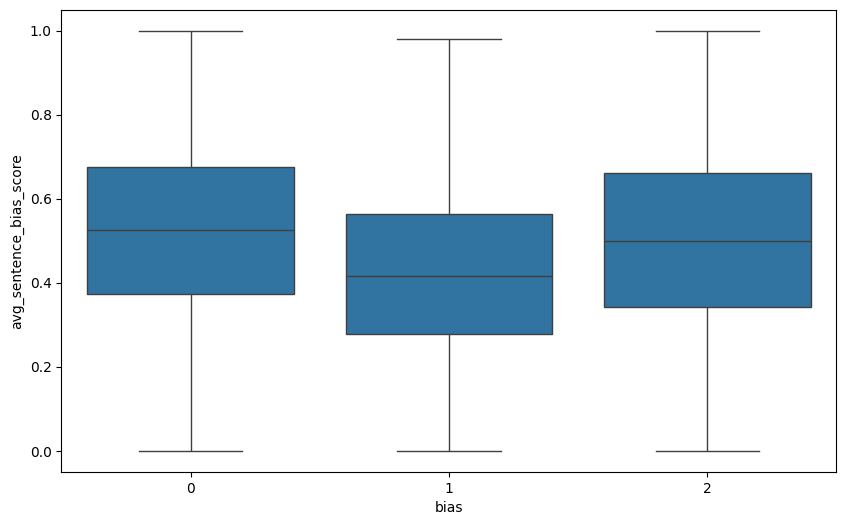

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a boxplot for avg_sentence_bias_score vs bias
plt.figure(figsize=(10, 6))
sns.boxplot(x='bias', y='avg_sentence_bias_score', data=train_pd_df_bias_score_merged)

# Print the median scores for all bias
median_scores = train_pd_df_bias_score_merged.groupby('bias')['avg_sentence_bias_score'].median()
print("Median scores for all bias:")
print(median_scores)

In [ ]:
# Load csv to Pandas for better performance
test_sentence_bias_df = pd.read_csv('/content/gdrive/MyDrive/spark_dataframes/test_sentence_bias_scores.csv', names=['ID', 'avg_sentence_bias_score'])
test_sentence_bias_df.head()

,ID,avg_sentence_bias_score
0,iZMWqqPVKECNZcNn,0.368421
1,LvjI1HqauPaFKJJv,0.277778
2,iLp5yYleqvNjL0YA,0.533333
3,J2hsNIYNhaB8Tpal,0.739583
4,cFe2UuHQ33z9YCwf,0.066667


In [ ]:
# Join test_pd_df to test_sentence_bias_df on 'ID' column
test_pd_df_bias_score_merged = test_pd_df.merge(test_sentence_bias_df, on='ID', how='left')
test_pd_df_bias_score_merged.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,avg_sentence_bias_score
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,0.718750
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,0.450000
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,0.366667
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,0.400000
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,0.620690


## Generate Media-Level Bias Score

### Preprocessing the Training Split

In [ ]:
# Print all media sources from the training dataset
print(train_pd_df['source'].unique())

['The Guardian' 'Washington Times' 'National Review' 'NPR Online News'
 'Bloomberg' 'Reuters' 'Politico' 'Christian Science Monitor'
 'TheBlaze.com' 'Fox Online News' 'American Spectator' 'Vox'
 'Washington Post' 'Business Insider' 'Fox News' 'ABC News' 'USA TODAY'
 'CNN (Web News)' 'Guest Writer - Left' 'The Hill' 'New York Times - News'
 'Associated Press' 'Daily Beast' 'Townhall' 'Guest Writer - Right'
 'Salon' 'CBS News' 'New York Post' 'CBN' 'Media Matters' 'Rich Lowry'
 'Breitbart News' 'Newsmax - News' 'New York Times - Opinion' 'BBC News'
 'ThinkProgress' 'RealClearPolitics' 'Newsmax' 'The Atlantic'
 'International Business Times' 'The Flip Side' 'Scientific American'
 'CNN - Editorial' 'Democracy Now' 'The Week - News' 'Fox News (Online)'
 'Ezra Klein' 'The Daily Caller' 'Yahoo! The 360' 'HotAir' 'MarketWatch'
 'The Intercept' 'Axios' 'Reason' 'John Stossel' 'Daily Kos' 'Daily Mail'
 'ProPublica' 'CNBC' 'Wall Street Journal - News' 'Howard Kurtz'
 'Al Jazeera' 'Vanity Fair' 'J

In [ ]:
len(train_pd_df['source'].unique())

192

In [ ]:
# Ratings received from https://www.allsides.com/media-bias/ratings as of 21 March 2025
# There are 5 categories: left (0), lean left (0.5), center (1), lean right (1.5), right (2)
# Each of the category will receive
allsides_media_bias_ratings = {
    "The Guardian": 0,
    "Washington Times": 1.5,
    "National Review": 1.5,
    "NPR Online News": 0.5,
    "Bloomberg": 0.5,
    "Reuters": 1,
    "Politico": 0.5,
    "Christian Science Monitor": 1,
    "TheBlaze.com": 2,
    "Fox Online News": 2,
    "ABC News": 0.5,
    "USA TODAY": 0.5,
    "CNN (Web News)": 0.5,
    "Guest Writer - Left": 0.5,
    "The Hill": 1,
    "New York Times - News": 0.5,
    "Associated Press": 0,
    "Daily Beast": 0,
    "Townhall": 2,
    "Guest Writer - Right": 1.5,
    "Salon": 0,
    "CBS News": 0.5,
    "New York Post": 1.5,
    "CBN": 2,
    "Media Matters": 0,
    "Rich Lowry": 2,
    "Breitbart News": 2,
    "Newsmax - News": 2,
    "New York Times - Opinion": 0,
    "BBC News": 1,
    "ThinkProgress": 0,
    "RealClearPolitics": 1.5,
    "Newsmax": 2,
    "The Atlantic": 0,
    "International Business Times": 1,
    "The Flip Side": 1,
    "Scientific American": 0.5,
    "CNN - Editorial": 0,
    "Democracy Now": 0,
    "The Week - News": 0.5,
    "Fox News (Online)": 2,
    "Ezra Klein": 0,
    "The Daily Caller": 2,
    "Yahoo! The 360": 1,
    "HotAir": 1.5,
    "MarketWatch": 1,
    "The Intercept": 0,
    "Axios": 0.5,
    "Reason": 1,
    "John Stossel": 1.5,
    "Daily Kos": 0,
    "Daily Mail": 2,
    "ProPublica": 0.5,
    "CNBC": 1,
    "Wall Street Journal - News": 1,
    "Howard Kurtz": 1,
    "Al Jazeera": 0.5,
    "Vanity Fair": 0.5,
    "Jacobin": 0,
    "The Economist": 0.5,
    "Dana Milbank": 0,
    "Slate": 0,
    "NBC News (Online)": 0.5,
    "Vice": 0,
    "The Nation": 0,
    "The Epoch Times": 1.5,
    "Victor Hanson": 1.5,
    "Charles Krauthammer": 1.5,
    "Rev. Jesse Jackson Sr.": 0,
    "Ben Shapiro": 2,
    "NewsBusters": 2,
    "New York Magazine": 0,
    "Time Magazine": 0.5,
    "Peter Thiel": 1.5,
    "Newt Gingrich": 2,
    "Mother Jones": 0,
    "Fox News Opinion": 2,
    "Michael Barone": 1.5,
    "Washington Free Beacon": 2,
    "The Daily Wire": 2,
    "New York Times (Online News)": 0.5,
    "The Boston Globe": 0,
    "Chicago Sun-Times": 0.5,
    "Michelle Malkin": 2,
    "Andrew Napolitano": 2,
    "Pew Research Center": 1,
    "Media Research Center": 2,
    "New York Post (Opinion)": 2,
    "NBCNews.com": 0.5,
    "BuzzFeed News": 0,
    "Yahoo! News": 0.5,
    "NPR Editorial ": 0.5,
    "The Marshall Project": 1,
    "Scott Walker": 2,
    "The New Yorker": 0,
    "New York Post (News)": 1.5,
    "Newsmax - Opinion": 2,
    "The Week - Opinion": 0.5,
    "Jonah Goldberg": 2,
    "Richard A. Lowry": 2,
    "John Fund": 1.5,
    "AllSides": 1, # Fixed: Added a colon
    "Newsmax (News)": 2,
    "Christopher Buskirk": 1.5, # Fixed: Added a comma
    "AP Fact Check": 0.5,
    "American Enterprise Institute": 1.5, # Fixed: Removed extra comma
    "Washington Examiner": 1.5,
    "Noah Rothman": 1.5,
    "Ann Coulter": 2,
    "Kathleen Parker": 1.5,
    "Mitch McConnell": 1.5,
    "Barack Obama": 0.5,
    "Dennis Prager": 2,
    "Thomas Sowell": 1.5,
    "Andrew Sullivan": 0,
    "Washington Post": 0.5,
    "Jesse Jackson": 0,
    "William Bennett": 2,
    "International Institute for Strategic Studies": 1,
    "Jonathan Chait": 0,
    "Matt Towery": 1.5,
    "Guest Writer - Center": 1,
    "Bret Stephens": 1.5,
    "Michael Goodwin": 2,
    "American Spectator": 2,
    "The American Spectator": 2,
    "Allysia Finley (Wall Street Journal)": 2,
    "Pat Buchanan": 2,
    "Ben Stein": 1.5,
    "Michael Brendan Dougherty": 1.5,
    "Mitt Romney": 1.5,
    "Joan Blades": 0,
    "Rem Reider": 1,
    "Fox News": 2,
    "Juan Williams": 0.5,
    "David Brooks": 1.5,
    "Ted Rall (cartoonist)": 0.5,
    "Billy Binion": 1,
    "Brent Bozell": 2,
    "Charles Blow": 0.5,
    "Conor Friedersdorf": 1,
    "Damon Linker": 0.5,
    "Elizabeth Warren": 0,
    "Gail Collins": 0,
    "Jim Obergefell": 0.5,
    "Jonathan Haidt": 1,
    "Julian Zelizer": 0.5,
    "Lisa Gable": 2,
    "Michael Kinsley": 0,
    "Annafi Wahed": 0.5,
    "David Leonhardt": 0.5,
    "Ryan Cooper": 0,
    "S.E. Cupp": 1.5,
    "Scott Jennings": 1.5,
    "Tom Nichols": 1.5,
    "ABC News (Online)": 0.5,
    "Business Insider": 0.5,
    "HuffPost": 0,
    "Ross Douthat": 1.5,
    "James Bovard": 1.5,
    "Tucker Carlson": 2,
    "George Will": 2,
    "Thomas Frank": 0.5,
    "Jeff Jacoby": 2,
    "Walt Handelsman (cartoonist)": 0,
    "Piers Morgan": 0.5,
    "Chris Ruddy": 2,
    "Salon": 0,
    "Michelle Goldberg": 0,
    "Jonathan Miller": 0,
    "Rand Paul": 1.5,
    "Nicholas Kristof": 0,
    "FiveThirtyEight": 1,
    "Jon Terbush": 0.5,
    "Matt Welch": 1.5,
    "Vox": 0,
    "Amy Klobuchar": 0.5,
    "Dick Morris": 1.5,
    "Carrie Lukas": 2,
    "Ralph Benko": 2,
    "Frank Bruni": 0.5,
    "John Boehner": 2,
    "Tom Cole": 2,
    "New York Times Editorial Board": 0,
    "NBC (Web News)": 0.5,
    "Wall Street Journal - Editorial": 1
}

In [ ]:
len(allsides_media_bias_ratings)

185

In [ ]:
# Add a column that has the source bias rating mapped according to the bias ratings
train_pd_df_media_score_merged = train_pd_df.copy()
train_pd_df_media_score_merged["source_bias_score"] = train_pd_df_media_score_merged["source"].map(allsides_media_bias_ratings)

In [ ]:
# Encode the source column using the LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_pd_df_media_score_merged["source_encoded"] = label_encoder.fit_transform(train_pd_df_media_score_merged["source"])

# Print all the unique source_encoded values
print(train_pd_df_media_score_merged["source_encoded"].unique())

[158 187 108 107  21 137 130  38 167  57   8 180 186  25  54   0 176  30
  63 159 114  14  41 174  64 144  28 110  27  92 139  22 120 115  16 168
 134 118 151  68 157 145  31  48 165  55  52 153 190  65  89 161  15 135
  78  42  43 131  29 182  66   4 177  70 155  45  32 148 104  53 178 163
 156 179  35 138  61  18 117 109 171 126 122 102  56  94 185 154 113 152
  36  99  10 127  93 112 105  26 189 106 162 147 164 111 121 166  80 140
  77   5 119  39   2   7  44  81   1  34  13  84 175  67 172  12  46  60
  79 173 181  83 170  73 124  50  96 146  75  85  72   6 125 143  47 133
  69  58  23  59  95 136  17 103 169 160  74 128  49  51 132  82  37 100
  62 101  90  40   3  86 141 184  87  98  91 142  20  24 129   9 123 116
 183  88 150  19 149 191  76 188  11  71  33  97]


In [ ]:
# Create a function that returns a DataFrame with the following columns: source, source_encoded, and source_bias_score.
# Only returns the rows that are unique.
def get_source_bias_score_df(df):
  return df[["source", "source_encoded", "source_bias_score"]].drop_duplicates().dropna()


get_source_bias_score_df(train_pd_df_media_score_merged)

,source,source_encoded,source_bias_score
0,The Guardian,158,0.0
1,Washington Times,187,1.5
2,National Review,108,1.5
3,NPR Online News,107,0.5
4,Bloomberg,21,0.5
...,...,...,...
25939,William Bennett,188,2.0
26469,Andrew Sullivan,11,0.0
26575,James Bovard,71,1.5
27476,Carrie Lukas,33,2.0


In [ ]:
# Drop any rows that have source_bias_score as N/A
train_pd_df_media_score_merged = train_pd_df_media_score_merged.dropna(subset=["source_bias_score"])

In [ ]:
len(train_pd_df_media_score_merged)
assert(len(train_pd_df_media_score_merged) == 27901)

In [ ]:
# Display any rows that have N/A value
train_pd_df_media_score_merged[train_pd_df_media_score_merged["source_bias_score"].isna()]

# Assert that there are no NA rows left
assert(len(train_pd_df_media_score_merged[train_pd_df_media_score_merged["source_bias_score"].isna()]) == 0)

Pearson correlation between source_bias_score and bias: 0.8954756680602131


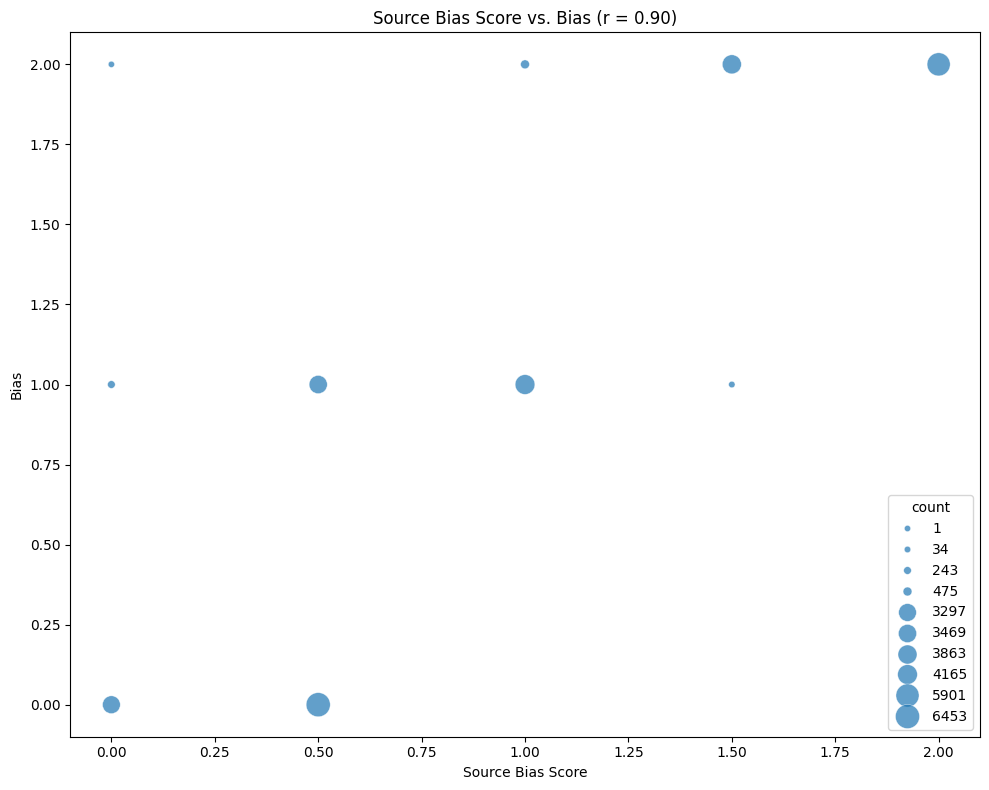

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Compute the Pearson correlation coefficient on the original data.
correlation = train_pd_df_media_score_merged['source_bias_score'].corr(train_pd_df_media_score_merged['bias'])
print("Pearson correlation between source_bias_score and bias:", correlation)

# Group by the two columns and count the number of occurrences.
grouped = train_pd_df_media_score_merged.groupby(['source_bias_score', 'bias']).size().reset_index(name='count')

# Create a scatter plot with each dot's size representing the count.
plt.figure(figsize=(10, 8))
sns.scatterplot(data=grouped,
                x='source_bias_score',
                y='bias',
                size='count',
                sizes=(20, 300),  # Adjust these values as needed for dot sizes
                legend="full",
                alpha=0.7)
plt.title(f"Source Bias Score vs. Bias (r = {correlation:.2f})")
plt.xlabel("Source Bias Score")
plt.ylabel("Bias")
plt.tight_layout()
plt.show()

### Preprocessing the Test Split

In [ ]:
# Add a column that has the source bias rating mapped according to the bias ratings
test_pd_df_media_score_merged = test_pd_df.copy()
test_pd_df_media_score_merged["source_bias_score"] = test_pd_df_media_score_merged["source"].map(allsides_media_bias_ratings)

# Encode the source column using the LabelEncoder
label_encoder = LabelEncoder()
test_pd_df_media_score_merged["source_encoded"] = label_encoder.fit_transform(test_pd_df_media_score_merged["source"])

# Drop any rows that have source_bias_score as N/A
test_pd_df_media_score_merged = test_pd_df_media_score_merged.dropna(subset=["source_bias_score"])

# Display any rows that have N/A value
test_pd_df_media_score_merged[test_pd_df_media_score_merged["source_bias_score"].isna()]

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,source_bias_score,source_encoded


In [ ]:
test_pd_df_media_score_merged.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,source_bias_score,source_encoded
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,2.0,8
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,0.5,0
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,1.0,23
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,2.0,10
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,2.0,8


## Merge Features

In [ ]:
# Add a feature column that determines if we should add or subtract the value of feat_avg_bias_score_sentences from the article's starting bias score of 1
# The operation will be based on the political leaning of the outlet where we would add the bias_score to 1 if the outlet is right-leaning, but subtract the score from 1 if the outlet is left-leaning.
# The political leaning of the news outlet will be determined based Allsides.com ratings

In [ ]:
# Merge bias scores with source bias and source encoded on training data
train_pd_df_final = train_pd_df_media_score_merged.merge(train_pd_df_bias_score_merged, left_index=True, right_index=True, how='outer', suffixes=('', '_y'))
train_pd_df_final.drop(train_pd_df_final.filter(regex='_y$').columns, axis=1, inplace=True)
train_pd_df_final.columns

Index(['topic', 'source', 'bias', 'url', 'title', 'date', 'authors', 'content',
       'content_original', 'source_url', 'bias_text', 'ID',
       'source_bias_score', 'source_encoded', 'avg_sentence_bias_score'],
      dtype='object')

In [ ]:
train_pd_df_final.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,source_bias_score,source_encoded,avg_sentence_bias_score
0,coronavirus,The Guardian,0.0,https://www.theguardian.com/world/2020/mar/26/...,US coronavirus stimulus checks: are you eligib...,2020-03-26,Lauren Aratani,Most taxpayers will get a check from the $ 2tn...,Most taxpayers will get a check from the $2tn ...,www.theguardian.com,left,IBgtqEHUEcjyMriR,0.0,158.0,0.214286
1,healthcare,Washington Times,2.0,http://www.washingtontimes.com/news/2013/feb/1...,After Obamacare health exchange deadline passe...,2013-02-16,Tom Howell Jr.,The backbone of President Obama ’ s health car...,The backbone of President Obama’s health care ...,www.washingtontimes.com,right,LC3zdsbACLILzBhY,1.5,187.0,0.217391
2,politics,National Review,2.0,https://www.nationalreview.com/2019/08/the-doj...,The DOJ Will Not Prosecute James Comey over Tr...,2019-08-03,"Andrew C. Mccarthy, John Mccormack, Michael Br...",Then-FBI Director James Comey testifying on Ca...,Then-FBI Director James Comey testifying on Ca...,www.nationalreview.com,right,W084H19Vniu1Z24f,1.5,108.0,0.622222
3,media_bias,NPR Online News,1.0,https://www.npr.org/2018/08/27/642356784/fox-n...,Fox News Hasn't Always Shared Robert Driscoll'...,2018-08-27,David Folkenflik,Fox News Has n't Always Shared Robert Driscoll...,Fox News Hasn't Always Shared Robert Driscoll'...,www.npr.org,center,Lcvv69hlu4J5Foc3,0.5,107.0,0.452381
4,trade,Bloomberg,1.0,https://www.bloomberg.com/news/articles/2019-0...,"Wilbur Ross Says U.S., China ‘Miles and Miles’...",2019-01-24,"Brendan Murray, Andrew Mayeda",LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,www.bloomberg.com,center,ZW7MmqXMtiJgL6jY,0.5,21.0,0.315789


In [ ]:
# Drop any NAN rows in test
train_pd_df_final = train_pd_df_final.dropna()

# See if train_pd_df_final has any NAN rows
train_pd_df_final[train_pd_df_final.isna().any(axis=1)]

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,source_bias_score,source_encoded,avg_sentence_bias_score


In [ ]:
# Merge bias scores with source bias and source encoded on test data
test_pd_df_final = test_pd_df_media_score_merged.merge(test_pd_df_bias_score_merged, left_index=True, right_index=True, how='outer', suffixes=('', '_y'))
test_pd_df_final.drop(test_pd_df_final.filter(regex='_y$').columns, axis=1, inplace=True)
test_pd_df_final.columns

Index(['topic', 'source', 'bias', 'url', 'title', 'date', 'authors', 'content',
       'content_original', 'source_url', 'bias_text', 'ID',
       'source_bias_score', 'source_encoded', 'avg_sentence_bias_score'],
      dtype='object')

In [ ]:
test_pd_df_final.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,source_bias_score,source_encoded,avg_sentence_bias_score
0,palestine,Breitbart News,2.0,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,2.0,8.0,0.718750
1,federal_budget,ABC News,0.0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,0.5,0.0,0.450000
2,fbi,Reuters,1.0,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,1.0,23.0,0.366667
3,politics,CBN,2.0,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,2.0,10.0,0.400000
4,media_bias,Breitbart News,2.0,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,2.0,8.0,0.620690


In [ ]:
# Drop any NAN rows in test
test_pd_df_final = test_pd_df_final.dropna()

# Show any NAN rows
test_pd_df_final[test_pd_df_final.isna().any(axis=1)]

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,source_bias_score,source_encoded,avg_sentence_bias_score


# Train Article-Level Classifier

## Classical Approach with TF-IDF
The classical approach encompasses utilizing TF-IDF vector weights and importing traditional classifiers such as logistic regression, XGBoost, etc.

### Setup
Load all libraries and setup code to be shared among all models.

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import shap
import numpy as np

In [ ]:
# Define a function that prints out accuracy report
def print_accuracy_report(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  print("Accuracy: {:.3f}\n".format(accuracy))
  print(report)

In [ ]:
# Define a function that preprocesses all the columns to be trained
def preprocess_training_columns(df, addition_features):
  X = df["content"]
  y = df["bias"]

  # Create a TF-IDF vectorizer from the text
  vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Use only unigrams and bigrams
    stop_words="english",
    max_features=50000,  # Reduce to 50K features
    min_df=10,  # Filter out rare words
    max_df=0.8,  # Exclude overly common words
    sublinear_tf=True
  )
  X_text = vectorizer.fit_transform(df['content'])

  scaler = StandardScaler()

  if addition_features:

    # Prepare the additional numeric features.
    additional_features = df[['avg_sentence_bias_score', 'source_encoded', 'source_bias_score']].values

    # Standardize these features to put them on a similar scale.
    X_additional_scaled = scaler.fit_transform(additional_features)

    # Convert the additional features to a sparse matrix.
    X_additional_sparse = csr_matrix(X_additional_scaled)

    # Combine the TF-IDF features with the additional features.
    X_final = hstack([X_text, X_additional_sparse])
  else:
    X_final = X_text

  # Get the target variable.
  y = df['bias']

  return {'X': X_final, 'y': y, 'tfidf-vectorizer': vectorizer, 'scaler': scaler}

In [ ]:
# Define a function that preprocesses all the columns to be predicted
def preprocess_test_columns(df, vectorizer, scaler, addition_features):
  X = df["content"]
  y = df["bias"]

  # Create a TF-IDF vectorizer from the text from the fitted vectorizer
  X_text = vectorizer.transform(df['content'])

  if addition_features:

    # Prepare the additional numeric features.
    additional_features = df[['avg_sentence_bias_score', 'source_encoded', 'source_bias_score']].values

    # Standardize these features to put them on a similar scale.
    X_additional_scaled = scaler.transform(additional_features)

    # Convert the additional features to a sparse matrix.
    X_additional_sparse = csr_matrix(X_additional_scaled)

    # Combine the TF-IDF features with the additional features.
    X_final = hstack([X_text, X_additional_sparse])
  else:
    X_final = X_text

  # Get the target variable.
  y = df['bias']

  return (X_final, y)

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType


def save_classifier(clf, filename, X_train):
  initial_types = [("float_input", FloatTensorType([None, X_train.shape[1]]))]
  onx = convert_sklearn(clf, initial_types=initial_types, target_opset=12, verbose=True)
  with open(filename, "wb") as f:
    f.write(onx.SerializeToString())

### Baseline Logistic Regression

In [ ]:
%%time


model = LogisticRegression(
    C=5,
    solver="saga",
    multi_class="multinomial",
    max_iter=3500,
    penalty="l2",
    random_state=42
)
result = preprocess_training_columns(train_pd_df_final, False)
model.fit(result['X'], result['y'])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: user 1min 10s, sys: 476 ms, total: 1min 10s
Wall time: 1min 10s


LogisticRegression(C=5, max_iter=3500, multi_class='multinomial',
                   random_state=42, solver='saga')

In [ ]:
%%time

X_test, y_test = preprocess_test_columns(test_pd_df_final, result['tfidf-vectorizer'], result['scaler'], False)
y_pred = model.predict(X_test)
print_accuracy_report(y_test, y_pred)

Accuracy: 0.731

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68       402
         1.0       0.68      0.86      0.76       298
         2.0       0.81      0.70      0.75       599

    accuracy                           0.73      1299
   macro avg       0.72      0.75      0.73      1299
weighted avg       0.74      0.73      0.73      1299

CPU times: user 1.26 s, sys: 1.91 ms, total: 1.26 s
Wall time: 1.26 s


<ipython-input-139-b52150c159b7>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


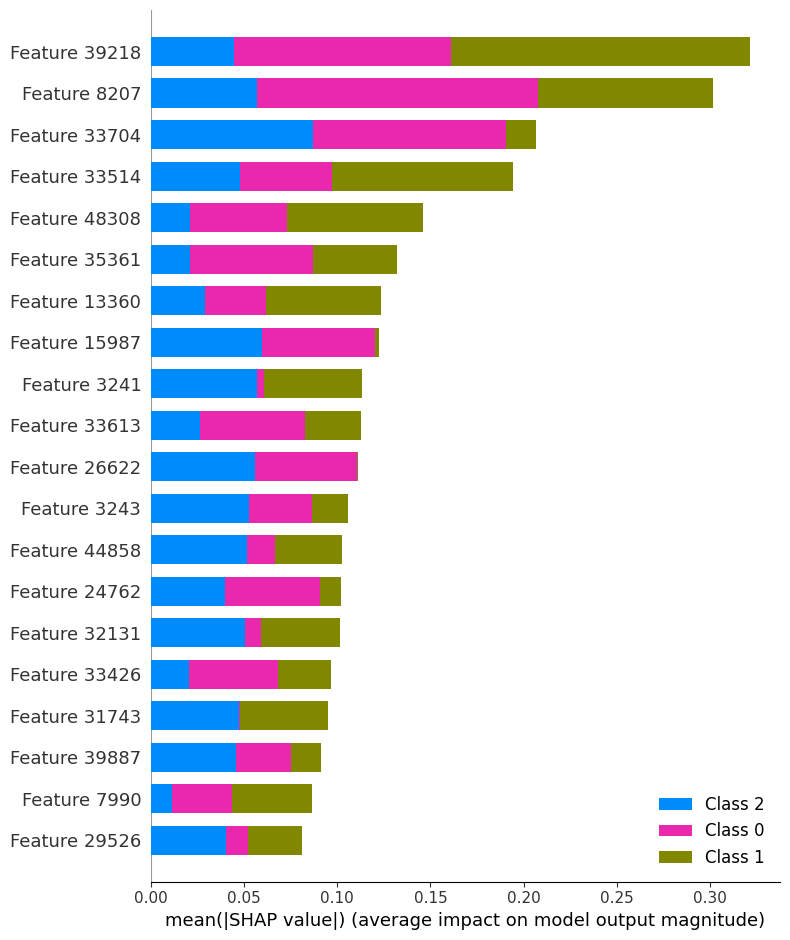

In [ ]:
explainer = shap.LinearExplainer(model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

### Logistic Regression and Featured Engineering

In [ ]:
%%time


model = LogisticRegression(
    C=5,
    solver="saga",
    multi_class="multinomial",
    max_iter=3500,
    penalty="l2",
    random_state=42
)
result = preprocess_training_columns(train_pd_df_final, True)
model.fit(result['X'], result['y'])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: user 2min 4s, sys: 1.73 s, total: 2min 6s
Wall time: 2min 5s


LogisticRegression(C=5, max_iter=3500, multi_class='multinomial',
                   random_state=42, solver='saga')

In [ ]:
%%time

X_test, y_test = preprocess_test_columns(test_pd_df_final, result['tfidf-vectorizer'], result['scaler'], True)
y_pred = model.predict(X_test)
print_accuracy_report(y_test, y_pred)

Accuracy: 0.869

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89       402
         1.0       0.71      0.73      0.72       298
         2.0       1.00      0.87      0.93       599

    accuracy                           0.87      1299
   macro avg       0.85      0.86      0.85      1299
weighted avg       0.88      0.87      0.87      1299

CPU times: user 1.32 s, sys: 2.87 ms, total: 1.33 s
Wall time: 1.32 s


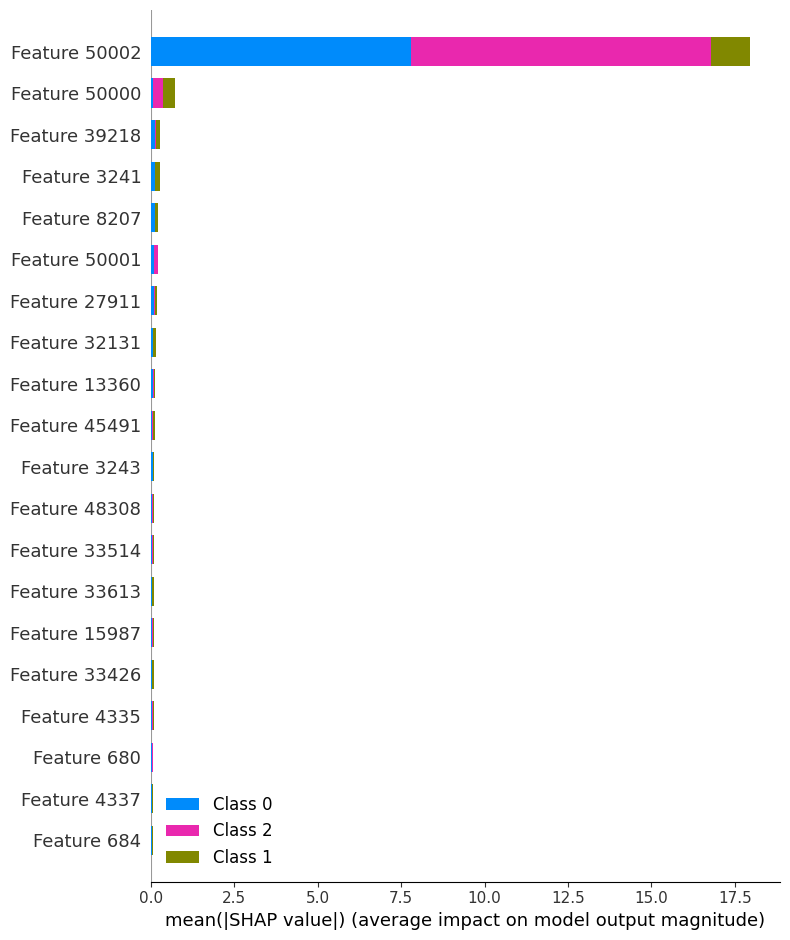

In [ ]:
explainer = shap.LinearExplainer(model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
# Save the classifier
X_train = result['X']
save_classifier(model, "/content/gdrive/MyDrive/spark_models/logreg.onnx", X_train)

[convert_sklearn] parse_sklearn_model
[convert_sklearn] convert_topology
[convert_operators] begin
[convert_operators] iteration 1 - n_vars=0 n_ops=2
[call_converter] call converter for 'SklearnLinearClassifier'.
[call_converter] call converter for 'SklearnZipMap'.
[convert_operators] end iter: 1 - n_vars=6
[convert_operators] iteration 2 - n_vars=6 n_ops=2
[convert_operators] end iter: 2 - n_vars=6
[convert_operators] end.
[_update_domain_version] +opset 0: name='ai.onnx.ml', version=1
[_update_domain_version] +opset 1: name='', version=9
[convert_sklearn] end


### SGDClassifier

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from collections import Counter

In [ ]:
%%time



X_train_text = train_pd_df_final["content"]
X_test_text = test_pd_df_final["content"]

X_train_extra = train_pd_df_final[["source_encoded", "source_bias_score"]]
X_test_extra = test_pd_df_final[["source_encoded", "source_bias_score"]]

y_train = train_pd_df_final["bias"]
y_test = test_pd_df_final["bias"]

# Normalize source features
scaler = MinMaxScaler()
X_train_extra = scaler.fit_transform(X_train_extra)
X_test_extra = scaler.transform(X_test_extra)

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Use only unigrams and bigrams
    stop_words="english",
    max_features=50000,  # Reduce to 50K features
    min_df=10,  # Filter out rare words
    max_df=0.8,  # Exclude overly common words
    sublinear_tf=True
)

X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# Reduce precision to save RAM
X_train_vec = X_train_vec.astype("float32")
X_test_vec = X_test_vec.astype("float32")

# Combine Text and Source Features
X_train_combined = hstack([X_train_vec, X_train_extra])
X_test_combined = hstack([X_test_vec, X_test_extra])

# SMOTE with Lower Sampling
bias_counts = Counter(y_train)
# Limit oversampling to avoid RAM issues
smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=3)
# Apply SMOTE to the combined features to ensure consistency.
X_train_final, y_train = smote.fit_resample(X_train_combined, y_train)

# Train XGBoost for Higher Accuracy
model = SGDClassifier(loss="log_loss", max_iter=1000, alpha=1e-4, penalty="l2", random_state=42)

model.fit(X_train_final, y_train)

# Predictions
# Use X_test_combined for prediction to maintain consistency.
y_test_pred = model.predict(X_test_combined)

# Performance Report
accuracy = accuracy_score(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("Test Accuracy: {:.3f}".format(accuracy))
print(report)

Test Accuracy: 0.895
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88       402
         1.0       0.86      0.66      0.75       298
         2.0       0.99      0.95      0.97       599

    accuracy                           0.90      1299
   macro avg       0.88      0.87      0.87      1299
weighted avg       0.90      0.90      0.89      1299

CPU times: user 1min 30s, sys: 3.48 s, total: 1min 34s
Wall time: 1min 30s


## Deep Learning Approach

### MultilayerPerceptronClassifier

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol(input_col) \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols("document") \
    .setOutputCol("sentence") \
    .setExplodeSentences(False)

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

bert_embeddings = BertEmbeddings().pretrained(name='small_bert_L4_256', lang='en') \
    .setInputCols(["sentence", 'token'])\
    .setOutputCol("embeddings")

sentence_embeddings = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

embeddings_finisher = EmbeddingsFinisher() \
    .setInputCols('sentence_embeddings', 'embeddings') \
    .setOutputCols('sentence_embeddings_vectors', 'embeddings_vectors') \
    .setOutputAsVector(True)

explode_vectors = SQLTransformer().setStatement("SELECT EXPLODE(sentence_embeddings_vectors) AS features, * FROM __THIS__")

vector_normalizer = Normalizer() \
    .setInputCol('features') \
    .setOutputCol(output_col) \
    .setP(1.0)

preprocessing_pipeline = Pipeline(
    stages=[
        document_assembler,
        sentence_detector,
        tokenizer,
        bert_embeddings,
        sentence_embeddings,
        embeddings_finisher,
        explode_vectors,
        vector_normalizer
])

# classsifierdl = ClassifierDLApproach()\
#     .setInputCols(["sentence_embeddings"])\
#     .setOutputCol("class")\
#     .setLabelColumn("bias")\
#     .setMaxEpochs(100)\
#     .setLr(0.001)\
#     .setEnableOutputLogs(True)
#     #.setOutputLogsPath('logs')

# pipeline = Pipeline(
#     stages=[
#         document_assembler,
#         tokenizer,
#         bert_embeddings,
#         embeddingsSentence,
#         classsifierdl
# ])

small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[ — ]
An error occurred while calling z:com.johnsnowlabs.nlp.pretrained.PythonResourceDownloader.downloadModel.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCom

Py4JJavaError: An error occurred while calling z:com.johnsnowlabs.nlp.pretrained.PythonResourceDownloader.downloadModel.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1654)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1639)
	at com.johnsnowlabs.nlp.serialization.Feature.$anonfun$setValue$1(Feature.scala:131)
	at scala.Option.map(Option.scala:230)
	at com.johnsnowlabs.nlp.serialization.Feature.setValue(Feature.scala:131)
	at com.johnsnowlabs.nlp.FeaturesReader.$anonfun$load$1(ParamsAndFeaturesReadable.scala:35)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at com.johnsnowlabs.nlp.FeaturesReader.load(ParamsAndFeaturesReadable.scala:33)
	at com.johnsnowlabs.nlp.FeaturesReader.load(ParamsAndFeaturesReadable.scala:24)
	at com.johnsnowlabs.nlp.pretrained.ResourceDownloader$.downloadModel(ResourceDownloader.scala:508)
	at com.johnsnowlabs.nlp.pretrained.ResourceDownloader$.downloadModel(ResourceDownloader.scala:500)
	at com.johnsnowlabs.nlp.pretrained.PythonResourceDownloader$.downloadModel(ResourceDownloader.scala:721)
	at com.johnsnowlabs.nlp.pretrained.PythonResourceDownloader.downloadModel(ResourceDownloader.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
from pyspark.sql.functions import col


train_df.groupBy("bias") \
      .count() \
      .orderBy(col("count").desc()) \
      .show()

+----+-----+
|bias|count|
+----+-----+
|   2|10241|
|   0| 8861|
|   1| 7488|
+----+-----+



In [ ]:
# Fit the pipeline on your training DataFrame and transform.
embedded_texts = preprocessing_pipeline.fit(train_df).transform(train_df)

In [ ]:
# Print all columns of the embedded_texts
print(embedded_texts.columns)

['features', 'topic', 'source', 'bias', 'url', 'title', 'date', 'authors', 'content', 'content_original', 'source_url', 'bias_text', 'ID', 'document', 'sentence', 'token', 'embeddings', 'sentence_embeddings', 'sentence_embeddings_vectors', 'embeddings_vectors', 'norm_features']


In [ ]:
# Print the size of the norm_features
print(embedded_texts.select(output_col).first()[0].size)

256


In [ ]:
%%time


# --- Now, set up the MLP classifier with specified layers ---
# For example, with small_bert_L4_256 the embeddings are 256-dimensional.
# Assume you have 3 classes for the label.
input_dim = 256    # Adjust this if your embeddings have a different size.
num_classes = 3    # For example, bias: left, center, right.
layers = [input_dim, 128, 64, num_classes]

mlp = MultilayerPerceptronClassifier(featuresCol=output_col,
                                       labelCol=label_col,
                                       maxIter=100,
                                       seed=42,
                                       layers=layers)

# Build a pipeline for training.
mlp_pipeline = Pipeline(stages=[mlp])

# Train the model.
model = mlp_pipeline.fit(embedded_texts)

In [ ]:
# get the predictions on test Set

preds = model.transform(test_df)

In [ ]:
preds.select('content','bias',"class.result").show(20, truncate=80)

In [ ]:
# log_file_name = os.listdir("/root/annotator_logs")[0]

# with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
#     print(log_file.read())

In [ ]:
# preds_df = preds.select('content','bias',"class.result").toPandas()
# preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))
# print (classification_report(preds_df['bias'], preds_df['result']))
# print(accuracy_score(preds_df['bias'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.46      0.32      0.37       402
           1       0.44      0.51      0.48       299
           2       0.53      0.60      0.56       599

    accuracy                           0.49      1300
   macro avg       0.48      0.48      0.47      1300
weighted avg       0.49      0.49      0.49      1300

0.49230769230769234


### Pretrained UniversalSentenceEncoder

In [ ]:
# Deep Learning Classifier Hyperparameters
batch_size = 64
max_epochs = 150
learning_rate = 1e-3  # default is 5e-3
dropout = 0.3

documentAssembler = DocumentAssembler() \
    .setInputCol(input_col) \
    .setOutputCol("document")

useEmbeddings = UniversalSentenceEncoder.pretrained() \
    .setInputCols("document") \
    .setOutputCol("sentence_embeddings")

docClassifier = ClassifierDLApproach() \
    .setInputCols("sentence_embeddings") \
    .setOutputCol('class') \
    .setLabelColumn(label_col) \
    .setBatchSize(batch_size) \
    .setMaxEpochs(max_epochs) \
    .setLr(learning_rate) \
    .setDropout(dropout) \
    .setEnableOutputLogs(True)

pipeline = Pipeline() \
    .setStages(
      [
        documentAssembler,
        useEmbeddings,
        docClassifier
      ]
    )

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
# Train the model

model = pipeline.fit(balanced_train_df)

log_file_name = os.listdir("/root/annotator_logs")[0]

with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
    print(log_file.read())

Training started - epochs: 150 - learning_rate: 0.001 - batch_size: 64 - training_examples: 30383 - classes: 3
Epoch 0/150 - 2.52s - loss: 503.0989 - acc: 0.47961763 - batches: 475
Epoch 1/150 - 2.15s - loss: 483.80713 - acc: 0.53496444 - batches: 475
Epoch 2/150 - 2.20s - loss: 476.44858 - acc: 0.5548748 - batches: 475
Epoch 3/150 - 2.21s - loss: 471.54807 - acc: 0.56815934 - batches: 475
Epoch 4/150 - 2.12s - loss: 467.94916 - acc: 0.57746714 - batches: 475
Epoch 5/150 - 2.14s - loss: 465.16995 - acc: 0.5854234 - batches: 475
Epoch 6/150 - 2.13s - loss: 462.9213 - acc: 0.59115916 - batches: 475
Epoch 7/150 - 2.15s - loss: 461.01865 - acc: 0.5963345 - batches: 475
Epoch 8/150 - 2.16s - loss: 459.31985 - acc: 0.6014321 - batches: 475
Epoch 9/150 - 2.18s - loss: 457.76135 - acc: 0.6059152 - batches: 475
Epoch 10/150 - 2.12s - loss: 456.3068 - acc: 0.6090138 - batches: 475
Epoch 11/150 - 2.13s - loss: 454.93906 - acc: 0.613377 - batches: 475
Epoch 12/150 - 2.14s - loss: 453.61697 - acc: 

In [ ]:
test_df.groupBy("bias").count().orderBy(col("count").desc()).show()

+----+-----+
|bias|count|
+----+-----+
|   2|  599|
|   0|  402|
|   1|  299|
+----+-----+



In [ ]:
# get the predictions on test Set

preds = model.transform(test_df)
preds.select('content', 'bias_text', 'bias',"class.result").show(20, truncate=120)

+------------------------------------------------------------------------------------------------------------------------+---------+----+------+
|                                                                                                                 content|bias_text|bias|result|
+------------------------------------------------------------------------------------------------------------------------+---------+----+------+
|For the last several days , the entire Western media has run with a false story : the story that Israeli Prime Minist...|    right|   2|   [0]|
|Tomorrow morning , House Budget Chairman Paul Ryan will release the latest version of his budget blueprint , setting ...|     left|   0|   [0]|
|WASHINGTON ( ███ ) - President Donald Trump on Friday blocked the release of a classified memo written by congression...|   center|   1|   [1]|
|President Donald Trump arrives in Hanoi , Vietnam , Tuesday for the two-day follow-up summit with North Korean dictat...|    righ

In [ ]:
preds_df = preds.select('content','bias',"class.result").toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))
print (classification_report(preds_df['bias'], preds_df['result']))
print(accuracy_score(preds_df['bias'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.47      0.46      0.46       402
           1       0.50      0.67      0.57       299
           2       0.65      0.56      0.60       599

    accuracy                           0.55      1300
   macro avg       0.54      0.56      0.55      1300
weighted avg       0.56      0.55      0.55      1300

0.5515384615384615


### Instructor Embeddings

In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from pyspark.ml import Pipeline
import pandas as pd

In [ ]:
# Deep Learning Classifier Hyperparameters
batch_size = 64
max_epochs = 120
learning_rate = 5e-3  # default is 5e-3
dropout = 0.5

documentAssembler = DocumentAssembler() \
    .setInputCol("content") \
    .setOutputCol("document")

# https://github.com/xlang-ai/instructor-embedding
embeddings = InstructorEmbeddings.pretrained() \
    .setInputCols(["document"]) \
    .setInstruction("Represent the document for categorical text classification: ") \
    .setOutputCol("instructor_embeddings")

classsifierdl = ClassifierDLApproach()\
    .setInputCols(["instructor_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("bias")\
    .setMaxEpochs(max_epochs)\
    .setBatchSize(batch_size)\
    .setLr(learning_rate) \
    .setDropout(dropout) \
    .setEnableOutputLogs(True)

pipeline = Pipeline().setStages([
     documentAssembler,
     embeddings,
     classsifierdl
 ])

instructor_base download started this may take some time.
Approximate size to download 387.2 MB
[OK!]


In [ ]:
# Train the model

model = pipeline.fit(balanced_train_df)

log_file_name = os.listdir("/root/annotator_logs")[0]

with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
    print(log_file.read())

Training started - epochs: 120 - learning_rate: 0.001 - batch_size: 64 - training_examples: 30619 - classes: 3
Epoch 0/120 - 2.64s - loss: 476.4277 - acc: 0.50760186 - batches: 479
Epoch 1/120 - 2.24s - loss: 440.29047 - acc: 0.58665425 - batches: 479
Epoch 2/120 - 2.37s - loss: 432.23807 - acc: 0.60925394 - batches: 479
Epoch 3/120 - 2.15s - loss: 427.1925 - acc: 0.6241598 - batches: 479
Epoch 4/120 - 2.14s - loss: 423.48785 - acc: 0.633913 - batches: 479
Epoch 5/120 - 2.17s - loss: 420.5115 - acc: 0.643981 - batches: 479
Epoch 6/120 - 2.22s - loss: 417.97812 - acc: 0.65022445 - batches: 479
Epoch 7/120 - 2.18s - loss: 415.77475 - acc: 0.65651274 - batches: 479
Epoch 8/120 - 2.15s - loss: 413.85312 - acc: 0.6620165 - batches: 479
Epoch 9/120 - 2.13s - loss: 412.1152 - acc: 0.6667563 - batches: 479
Epoch 10/120 - 2.13s - loss: 410.53696 - acc: 0.67129993 - batches: 479
Epoch 11/120 - 2.18s - loss: 409.1043 - acc: 0.6753533 - batches: 479
Epoch 12/120 - 2.22s - loss: 407.7822 - acc: 0.6

In [ ]:
# get the predictions on test Set

preds = model.transform(test_df)
preds.select('content', 'bias_text', 'bias',"class.result").show(20, truncate=120)

+------------------------------------------------------------------------------------------------------------------------+---------+----+------+
|                                                                                                                 content|bias_text|bias|result|
+------------------------------------------------------------------------------------------------------------------------+---------+----+------+
|For the last several days , the entire Western media has run with a false story : the story that Israeli Prime Minist...|    right|   2|   [2]|
|Tomorrow morning , House Budget Chairman Paul Ryan will release the latest version of his budget blueprint , setting ...|     left|   0|   [2]|
|WASHINGTON ( ███ ) - President Donald Trump on Friday blocked the release of a classified memo written by congression...|   center|   1|   [1]|
|President Donald Trump arrives in Hanoi , Vietnam , Tuesday for the two-day follow-up summit with North Korean dictat...|    righ

In [ ]:
preds_df = preds.select('content','bias',"class.result").toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))
print (classification_report(preds_df['bias'], preds_df['result']))
print(accuracy_score(preds_df['bias'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.51      0.45      0.48       402
           1       0.51      0.79      0.62       299
           2       0.65      0.53      0.58       599

    accuracy                           0.56      1300
   macro avg       0.56      0.59      0.56      1300
weighted avg       0.57      0.56      0.56      1300

0.5623076923076923


The accuracy of the test dataset shows that the model overfits the training dataset and doesn't generalize well.

In [ ]:
# Print the top news sources for the training dataset, descending, limit 20
train_pd_df['source'].value_counts()[:20]

,count
source,
Washington Times,2328
CNN (Web News),2234
Politico,1998
NPR Online News,1614
Fox Online News,1611
USA TODAY,1441
Vox,1160
New York Times - News,1115
Fox News,1103


In [ ]:
# Print news sources for the test dataset
test_pd_df['source'].value_counts()[:20]

,count
source,
CNN (Web News),101
BBC News,100
The Guardian,100
Reuters,100
Associated Press,98
Salon,98
The Daily Caller,98
CBN,98
ABC News,97


### Doc2Vec

In [ ]:
# Import the required modules and classes
from sparknlp.annotator import (
    SentenceDetector,
    StopWordsCleaner,
    Doc2VecModel
)
from pyspark.ml.feature import SQLTransformer
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
import pyspark

# Set the input and output columns
input_col = 'content'
output_col = 'norm_features'
label_col = 'bias'

document_assembler = DocumentAssembler() \
    .setInputCol(input_col) \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

embeddings = Doc2VecApproach() \
    .setInputCols(["token"]) \
    .setOutputCol("embeddings") \
    .setMinCount(2)

embeddings_finisher = EmbeddingsFinisher() \
    .setInputCols("embeddings") \
    .setOutputCols("finished_embeddings") \
    .setOutputAsVector(True)

explode_vectors = SQLTransformer().setStatement("SELECT EXPLODE(finished_embeddings) AS features, * FROM __THIS__")

vector_normalizer = pyspark.ml.feature.Normalizer() \
    .setInputCol('features') \
    .setOutputCol(output_col) \
    .setP(1.0)

preprocessing_pipeline = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        embeddings,
        embeddings_finisher,
        explode_vectors,
        vector_normalizer
])

In [ ]:
# Proprocess the training dataset
result = preprocessing_pipeline.fit(balanced_train_df).transform(balanced_train_df)

# Show the features column
result.select(output_col).show(truncate=80)

+--------------------------------------------------------------------------------+
|                                                                   norm_features|
+--------------------------------------------------------------------------------+
|[0.007798037100142348,5.071644299569688E-4,-0.012680488063702861,0.0131453620...|
|[0.016862608260338172,-0.002827231760711542,-0.011145063571504089,0.011833234...|
|[0.014045452890046646,-6.590362522728323E-4,-0.014196252995049674,0.007096697...|
|[0.014045452890046646,-6.590362522728323E-4,-0.014196252995049674,0.007096697...|
|[0.01011915033275805,-0.0051526903068590335,-0.011114679613857063,0.015036446...|
|[0.01011915033275805,-0.0051526903068590335,-0.011114679613857063,0.015036446...|
|[0.01610966808056948,-0.007634306396329289,-0.0181064340772751,0.017997191356...|
|[0.01172238000849705,-0.011723457956783376,-0.017901176926311314,0.0042711351...|
|[0.01172238000849705,-0.011723457956783376,-0.017901176926311314,0.0042711351...|
|[0.

In [ ]:
%%time

# Build a pipeline for training.
lr = LogisticRegression(featuresCol=output_col, labelCol=label_col, maxIter=10)
pipeline = Pipeline(stages=[lr])

# Train the model.
model = pipeline.fit(result)

CPU times: user 1.21 s, sys: 199 ms, total: 1.41 s
Wall time: 5min 1s


In [ ]:
# Preprocess the test dataset
result = preprocessing_pipeline.fit(test_df).transform(test_df)

# Show the features column
result.select(output_col).show(truncate=80)

+--------------------------------------------------------------------------------+
|                                                                   norm_features|
+--------------------------------------------------------------------------------+
|[-0.01166956671727528,0.008745392936276412,-0.00293264637126144,0.00579963378...|
|[-0.004467710899253843,0.002223761908222078,-0.0016820653219923993,-0.0038028...|
|[-0.005549589814232439,0.01393451088582145,-0.009889423405457575,0.0056161615...|
|[-0.009076889800591861,0.01105205290333825,-0.005553708068240578,-0.005125876...|
|[-0.011425702005318861,0.012935818121574856,-0.012462009499245095,-0.00363831...|
|[-0.005890293302576278,0.006329802153506408,-0.0036046848245581877,-0.0047646...|
|[-0.005204271713491326,0.008107848583792897,-0.002316265351984269,0.002311856...|
|[-0.005579054183054723,0.001118056515474404,-0.0030472918273197883,-0.0048634...|
|[-0.02298187195452969,0.0031330452409459933,0.0019513632492702087,-0.00941623...|
|[-0

In [ ]:
# Use the trained model to get the test prediction
preds = model.transform(result)
preds.select('content', label_col, 'prediction').show(20, truncate=120)

+------------------------------------------------------------------------------------------------------------------------+----+----------+
|                                                                                                                 content|bias|prediction|
+------------------------------------------------------------------------------------------------------------------------+----+----------+
|Has the media gotten worse ? Or am I just grouchier ?\nEvery day I see things that are wrong or that so miss the poin...|   2|       2.0|
|Fort Worth ISD employee Yolanda Cintron assists with a deep cleaning at the Leadership Academy at John T. White Eleme...|   1|       0.0|
|With Congress heading toward another government shutdown , House Speaker Paul Ryan says he is “ hoping today ” that n...|   0|       2.0|
|The White House Commission on Combating Drug Addiction and the Opioid Crisis has asked President Donald Trump to “ de...|   0|       2.0|
|In 2004 , after the open s

In [ ]:
preds_df = preds.select('content', label_col, 'prediction').toPandas()
preds_df['result'] = preds_df['prediction'].apply(lambda x : int(x))
print (classification_report(preds_df['bias'], preds_df['result']))
print(accuracy_score(preds_df['bias'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.09      0.03      0.05       402
           1       0.38      0.01      0.02       299
           2       0.47      0.91      0.62       599

    accuracy                           0.43      1300
   macro avg       0.31      0.32      0.23      1300
weighted avg       0.33      0.43      0.31      1300

0.4323076923076923


# Cleaning and Miscellaneous Tasks

In [ ]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 9.9 MB/s eta 0:00:00


In [ ]:
from tldextract import extract


# Step 1: Extract the domain from the 'url' column.
train_pd_df_final['domain'] = train_pd_df_final['url'].apply(lambda x: extract(x).domain)

# Step 2: Group by domain and source, then count occurrences.
domain_source_counts = (
    train_pd_df_final
    .groupby(['domain', 'source'])
    .size()
    .reset_index(name='count')
)

# Step 3: For each domain, select the source with the highest count.
domain_source_sorted = domain_source_counts.sort_values(['domain', 'count'], ascending=[True, False])
mapping_df = domain_source_sorted.drop_duplicates(subset=['domain'])

# mapping_df now has columns: "domain", "source", "count"

# Step 4: Merge mapping_df with source_bias_df on the "source" column.
# Assume source_bias_df has columns: "source", "source_encoded", "source_bias_score".
source_bias_df = get_source_bias_score_df(train_pd_df_final)
final_mapping_df = mapping_df.merge(source_bias_df, on="source", how="left")

# Display the final mapping.
final_mapping_df

,domain,source,count,source_encoded,source_bias_score
0,aljazeera,Al Jazeera,104,4.0,0.5
1,allsides,National Review,3,108.0,1.5
2,apnews,Associated Press,235,14.0,0.0
3,axios,Axios,62,15.0,0.5
4,bbc,BBC News,603,16.0,1.0
...,...,...,...,...,...
69,vox,Vox,1159,180.0,0.0
70,washingtonpost,Washington Post,87,186.0,0.5
71,washingtontimes,Washington Times,2326,187.0,1.5
72,wsj,Wall Street Journal - News,277,182.0,1.0


In [ ]:
# Write the final_mapping_df to a csv
final_mapping_df.to_csv('/content/gdrive/MyDrive/spark_dataframes/source_bias_score.csv')

In [ ]:
# Save test_pd_df_final to a csv
test_pd_df_final.to_csv('/content/gdrive/MyDrive/spark_dataframes/test_pd_df_final.csv')

In [ ]:
import pickle


# Save the TF-IDF vectorizer
assert(type(result['tfidf-vectorizer']) == TfidfVectorizer)
with open('/content/gdrive/MyDrive/spark_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(result['tfidf-vectorizer'], f)

In [ ]:
# Save the Scaler
assert(type(result['scaler']) == StandardScaler)
with open('/content/gdrive/MyDrive/spark_models/scaler.pkl', 'wb') as f:
    pickle.dump(result['scaler'], f)

# Stop Spark Session

In [ ]:
# Terminate spark session
spark.stop()

NameError: name 'spark' is not defined